In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.layers import *
from tensorflow.keras.layers import Flatten
from keras.layers import Bidirectional
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler

mpl.rcParams['figure.figsize'] = (20, 6)
mpl.rcParams['axes.grid'] = False

2023-12-06 08:12:12.961607: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-06 08:12:13.007870: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-06 08:12:13.007903: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-06 08:12:13.008877: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-06 08:12:13.014116: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-06 08:12:13.021385: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
model_data = pd.read_csv("../../przygotowanie_danych/model_data.csv")
model_data.drop(model_data.index[:2151], inplace=True)
model_data


,Unnamed: 0,stacja,rok,miesiąc,dzień,temperatura,suma opadów,wilgotność,prędkość wiatru,zachmurzenine,day_number_in_year,PM2.5
2151,2191,KRAKÓW-OBSERWATORIUM,2020,1,1,2.6,0.0,75.8,3.0,4.3,1,21.62
2152,2192,KRAKÓW-OBSERWATORIUM,2020,1,2,0.4,0.0,64.5,1.3,4.7,2,48.07
2153,2193,KRAKÓW-OBSERWATORIUM,2020,1,3,0.3,0.0,69.3,2.0,0.7,3,74.44
2154,2194,KRAKÓW-OBSERWATORIUM,2020,1,4,3.8,3.3,77.5,4.3,7.7,4,10.98
2155,2195,KRAKÓW-OBSERWATORIUM,2020,1,5,1.3,0.0,67.8,3.0,5.0,5,11.44
...,...,...,...,...,...,...,...,...,...,...,...,...
3482,3525,KRAKÓW-OBSERWATORIUM,2023,8,27,22.2,0.5,85.3,0.7,3.7,239,9.90
3483,3526,KRAKÓW-OBSERWATORIUM,2023,8,28,19.7,0.1,89.5,1.7,8.0,240,8.40
3484,3527,KRAKÓW-OBSERWATORIUM,2023,8,29,21.0,0.9,89.0,1.0,7.7,241,10.20
3485,3528,KRAKÓW-OBSERWATORIUM,2023,8,30,18.5,0.3,89.5,1.3,7.7,242,8.40


<Axes: >

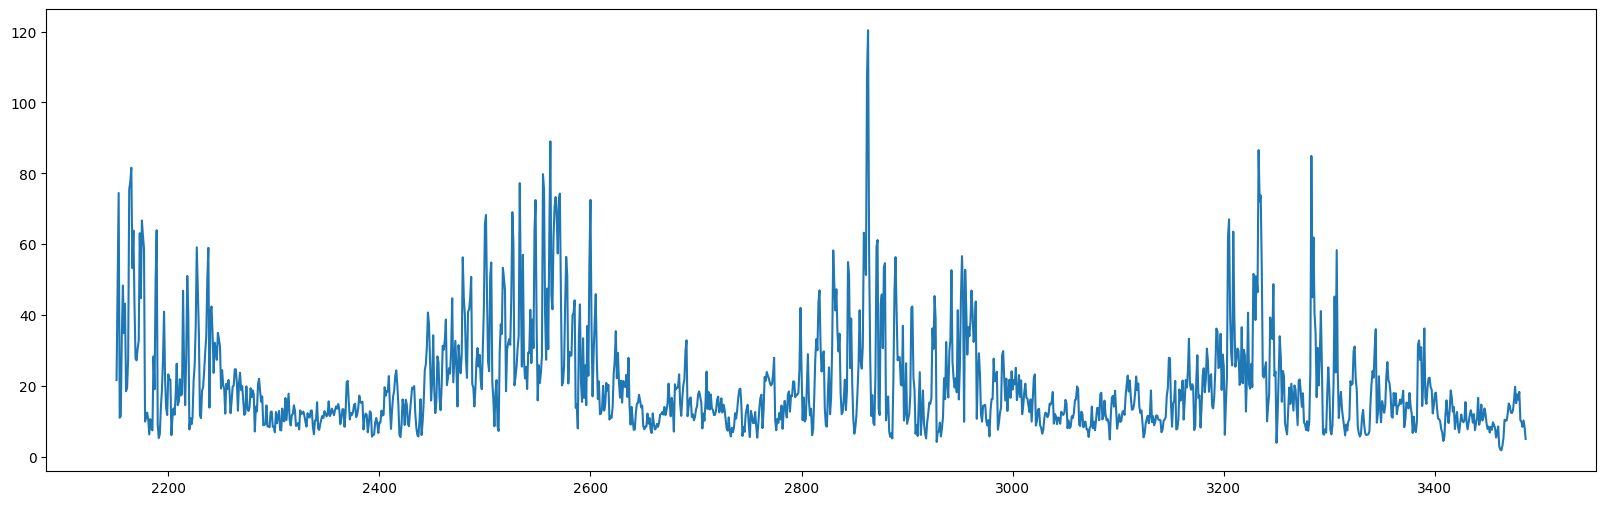

In [3]:
df2 = model_data.drop(model_data.columns[[0,1,2,3,4]],axis = 1)
model_data = df2
model_data.describe()
PM = model_data['PM2.5']
model_data['PM2.5'].plot()



In [38]:

X = model_data[["temperatura", "suma opadów", "wilgotność", "prędkość wiatru", "zachmurzenine", "day_number_in_year"]] #usunać dni
y = model_data[['PM2.5']]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.04, random_state=42,shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.75, random_state=42,shuffle=False)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.fit_transform(X_val)
X_test_scaled = scaler.transform(X_test)



print(X_train_scaled.shape)
print(X_val_scaled.shape)
print(X_test_scaled.shape)


y_train = y_train['PM2.5']
y_test = y_test['PM2.5']
y_val = y_val['PM2.5']

(1282, 6)
(13, 6)
(41, 6)


In [5]:
from sklearn.metrics import mean_squared_error as mse
def plot_predictions1(model, X, y, start=0, end=X_test_scaled.shape[0]):
  predictions = model.predict(X).flatten()
  df = pd.DataFrame(data={'Predictions': predictions, 'Actuals':y})
  plt.plot(df['Predictions'][start:end])
  plt.plot(df['Actuals'][start:end])
  print(mse(predictions, y))
  return mse(predictions, y)


In [39]:

early_stopping = EarlyStopping(monitor='val_loss', patience=200, restore_best_weights=True)

input_dim = X_train_scaled.shape[1]

model = Sequential()
# model.add(Conv1D(64, kernel_size=6, activation='relu', input_shape=(1,6), padding='same'))
# model.add(MaxPooling1D(2, padding='same'))
# model.add(Conv1D(128, kernel_size=3, activation='relu', padding='same'))
# model.add(MaxPooling1D(2, padding='same'))
model.add(LSTM(64, activation='relu',input_shape=(1, 6), return_sequences=True))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(256, return_sequences=True))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(48, return_sequences=True))
model.add(Flatten())
model.add(Dense(1, activation='linear'))

model.summary()

cp = ModelCheckpoint('model18/', save_best_only=True, monitor='val_mse')
cp_loss = ModelCheckpoint('model19/', save_best_only=True, monitor='mse')
model.compile(optimizer=Adam(learning_rate=0.0001), loss=tf.keras.losses.Huber(), metrics='mse')  
model.fit(X_train_scaled.reshape((X_train_scaled.shape[0], 1, 6)), y_train, 
          validation_data=(X_test_scaled.reshape((X_test_scaled.shape[0], 1, 6)), y_test),
          epochs=1000, callbacks=[cp,cp_loss,early_stopping])




Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 1, 64)             2368      
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 1, 64)             0         
 g1D)                                                            
                                                                 
 conv1d_7 (Conv1D)           (None, 1, 128)            24704     
                                                                 
 max_pooling1d_7 (MaxPoolin  (None, 1, 128)            0         
 g1D)                                                            
                                                                 
 lstm_16 (LSTM)              (None, 1, 64)             49408     
                                                                 
 lstm_17 (LSTM)              (None, 1, 128)           

INFO:tensorflow:Assets written to: model18/assets


INFO:tensorflow:Assets written to: model19/assets


INFO:tensorflow:Assets written to: model19/assets


41/41 [==============================] - 35s 681ms/step - loss: 20.2726 - mse: 644.0154 - val_loss: 9.5281 - val_mse: 118.9458
Epoch 2/1000
39/41 [===========================>..] - ETA: 0s - loss: 20.2615 - mse: 643.3701INFO:tensorflow:Assets written to: model18/assets


INFO:tensorflow:Assets written to: model18/assets


INFO:tensorflow:Assets written to: model19/assets


INFO:tensorflow:Assets written to: model19/assets


41/41 [==============================] - 27s 674ms/step - loss: 20.2165 - mse: 641.7031 - val_loss: 9.4515 - val_mse: 117.4150
Epoch 3/1000
39/41 [===========================>..] - ETA: 0s - loss: 20.1483 - mse: 638.6053INFO:tensorflow:Assets written to: model18/assets


INFO:tensorflow:Assets written to: model18/assets


INFO:tensorflow:Assets written to: model19/assets


INFO:tensorflow:Assets written to: model19/assets


41/41 [==============================] - 26s 659ms/step - loss: 20.0998 - mse: 636.8775 - val_loss: 9.2535 - val_mse: 113.5048
Epoch 4/1000
40/41 [============================>.] - ETA: 0s - loss: 19.6063 - mse: 617.4130INFO:tensorflow:Assets written to: model18/assets


INFO:tensorflow:Assets written to: model18/assets


INFO:tensorflow:Assets written to: model19/assets


INFO:tensorflow:Assets written to: model19/assets


41/41 [==============================] - 27s 668ms/step - loss: 19.5971 - mse: 616.9047 - val_loss: 7.1898 - val_mse: 75.9880
Epoch 5/1000
40/41 [============================>.] - ETA: 0s - loss: 13.8304 - mse: 417.4744INFO:tensorflow:Assets written to: model18/assets


INFO:tensorflow:Assets written to: model18/assets


INFO:tensorflow:Assets written to: model19/assets


INFO:tensorflow:Assets written to: model19/assets


41/41 [==============================] - 27s 663ms/step - loss: 13.8157 - mse: 416.8606 - val_loss: 6.4097 - val_mse: 62.6444
Epoch 6/1000
40/41 [============================>.] - ETA: 0s - loss: 9.3894 - mse: 236.6271INFO:tensorflow:Assets written to: model19/assets


INFO:tensorflow:Assets written to: model19/assets


41/41 [==============================] - 14s 339ms/step - loss: 9.3879 - mse: 236.3832 - val_loss: 7.1123 - val_mse: 73.9414
Epoch 7/1000
41/41 [==============================] - 1s 16ms/step - loss: 9.3536 - mse: 237.6853 - val_loss: 6.7435 - val_mse: 67.8670
Epoch 8/1000
41/41 [==============================] - 1s 15ms/step - loss: 9.3345 - mse: 238.4958 - val_loss: 6.4637 - val_mse: 63.4045
Epoch 9/1000
41/41 [==============================] - ETA: 0s - loss: 9.3212 - mse: 236.1299INFO:tensorflow:Assets written to: model19/assets


INFO:tensorflow:Assets written to: model19/assets


41/41 [==============================] - 13s 316ms/step - loss: 9.3212 - mse: 236.1299 - val_loss: 6.8612 - val_mse: 69.7781
Epoch 10/1000
41/41 [==============================] - 1s 15ms/step - loss: 9.3128 - mse: 238.1973 - val_loss: 6.4750 - val_mse: 63.5681
Epoch 11/1000
41/41 [==============================] - ETA: 0s - loss: 9.2931 - mse: 236.8730INFO:tensorflow:Assets written to: model18/assets


INFO:tensorflow:Assets written to: model18/assets


41/41 [==============================] - 14s 343ms/step - loss: 9.2931 - mse: 236.8730 - val_loss: 6.4035 - val_mse: 62.4388
Epoch 12/1000
40/41 [============================>.] - ETA: 0s - loss: 9.2929 - mse: 232.9871INFO:tensorflow:Assets written to: model19/assets


INFO:tensorflow:Assets written to: model19/assets


41/41 [==============================] - 14s 347ms/step - loss: 9.2855 - mse: 232.6685 - val_loss: 6.5649 - val_mse: 64.9842
Epoch 13/1000
41/41 [==============================] - ETA: 0s - loss: 9.2843 - mse: 237.2183INFO:tensorflow:Assets written to: model18/assets


INFO:tensorflow:Assets written to: model18/assets


41/41 [==============================] - 14s 349ms/step - loss: 9.2843 - mse: 237.2183 - val_loss: 6.3553 - val_mse: 61.6701
Epoch 14/1000
41/41 [==============================] - 1s 16ms/step - loss: 9.2726 - mse: 232.8876 - val_loss: 6.3901 - val_mse: 62.2126
Epoch 15/1000
40/41 [============================>.] - ETA: 0s - loss: 9.2827 - mse: 237.4585INFO:tensorflow:Assets written to: model18/assets


INFO:tensorflow:Assets written to: model18/assets


41/41 [==============================] - 14s 355ms/step - loss: 9.2719 - mse: 237.1006 - val_loss: 6.1969 - val_mse: 59.1919
Epoch 16/1000
40/41 [============================>.] - ETA: 0s - loss: 9.2719 - mse: 235.6591INFO:tensorflow:Assets written to: model18/assets


INFO:tensorflow:Assets written to: model18/assets


41/41 [==============================] - 14s 353ms/step - loss: 9.2640 - mse: 235.3274 - val_loss: 6.1505 - val_mse: 58.4727
Epoch 17/1000
41/41 [==============================] - 1s 16ms/step - loss: 9.2647 - mse: 237.8038 - val_loss: 6.2521 - val_mse: 60.0387
Epoch 18/1000
40/41 [============================>.] - ETA: 0s - loss: 9.2783 - mse: 229.6951INFO:tensorflow:Assets written to: model19/assets


INFO:tensorflow:Assets written to: model19/assets


41/41 [==============================] - 13s 326ms/step - loss: 9.2712 - mse: 229.4089 - val_loss: 6.3643 - val_mse: 61.7903
Epoch 19/1000
41/41 [==============================] - 1s 16ms/step - loss: 9.2575 - mse: 233.6734 - val_loss: 6.2381 - val_mse: 59.8139
Epoch 20/1000
41/41 [==============================] - 1s 16ms/step - loss: 9.2499 - mse: 231.3875 - val_loss: 6.4308 - val_mse: 62.8325
Epoch 21/1000
41/41 [==============================] - 1s 16ms/step - loss: 9.2513 - mse: 230.2592 - val_loss: 6.4514 - val_mse: 63.1568
Epoch 22/1000
41/41 [==============================] - 1s 16ms/step - loss: 9.2475 - mse: 234.0132 - val_loss: 6.1593 - val_mse: 58.5853
Epoch 23/1000
41/41 [==============================] - 1s 15ms/step - loss: 9.2444 - mse: 234.1477 - val_loss: 6.3354 - val_mse: 61.3229
Epoch 24/1000
41/41 [==============================] - 1s 14ms/step - loss: 9.2507 - mse: 229.9881 - val_loss: 6.2800 - val_mse: 60.4539
Epoch 25/1000
38/41 [==========================>...] 

INFO:tensorflow:Assets written to: model18/assets


41/41 [==============================] - 14s 350ms/step - loss: 9.2436 - mse: 232.7161 - val_loss: 6.1237 - val_mse: 58.0321
Epoch 26/1000
41/41 [==============================] - 1s 16ms/step - loss: 9.2378 - mse: 233.2800 - val_loss: 6.2641 - val_mse: 60.2011
Epoch 27/1000
41/41 [==============================] - 1s 15ms/step - loss: 9.2415 - mse: 230.2850 - val_loss: 6.3532 - val_mse: 61.5953
Epoch 28/1000
41/41 [==============================] - 1s 16ms/step - loss: 9.2369 - mse: 231.4323 - val_loss: 6.2250 - val_mse: 59.5899
Epoch 29/1000
39/41 [===========================>..] - ETA: 0s - loss: 9.2056 - mse: 231.3368INFO:tensorflow:Assets written to: model18/assets


INFO:tensorflow:Assets written to: model18/assets


41/41 [==============================] - 14s 343ms/step - loss: 9.2417 - mse: 232.4293 - val_loss: 5.9518 - val_mse: 55.4157
Epoch 30/1000
41/41 [==============================] - 1s 16ms/step - loss: 9.2396 - mse: 232.0088 - val_loss: 6.0935 - val_mse: 57.5617
Epoch 31/1000
41/41 [==============================] - 1s 16ms/step - loss: 9.2349 - mse: 233.1480 - val_loss: 6.0864 - val_mse: 57.4520
Epoch 32/1000
41/41 [==============================] - 1s 15ms/step - loss: 9.2402 - mse: 234.5611 - val_loss: 6.0338 - val_mse: 56.6508
Epoch 33/1000
41/41 [==============================] - 1s 15ms/step - loss: 9.2341 - mse: 232.4780 - val_loss: 6.2745 - val_mse: 60.3574
Epoch 34/1000
41/41 [==============================] - 1s 15ms/step - loss: 9.2325 - mse: 231.2290 - val_loss: 6.1149 - val_mse: 57.8868
Epoch 35/1000
41/41 [==============================] - 1s 15ms/step - loss: 9.2367 - mse: 234.7025 - val_loss: 6.1332 - val_mse: 58.1661
Epoch 36/1000
41/41 [==============================] 

INFO:tensorflow:Assets written to: model19/assets


41/41 [==============================] - 14s 345ms/step - loss: 9.2521 - mse: 226.6936 - val_loss: 6.2650 - val_mse: 60.2034
Epoch 43/1000
41/41 [==============================] - 1s 16ms/step - loss: 9.2355 - mse: 234.3312 - val_loss: 6.0435 - val_mse: 56.7911
Epoch 44/1000
41/41 [==============================] - 1s 15ms/step - loss: 9.2333 - mse: 234.7694 - val_loss: 6.0579 - val_mse: 57.0103
Epoch 45/1000
41/41 [==============================] - 1s 19ms/step - loss: 9.2315 - mse: 232.5504 - val_loss: 6.1141 - val_mse: 57.8685
Epoch 46/1000
41/41 [==============================] - 1s 18ms/step - loss: 9.2307 - mse: 231.3356 - val_loss: 6.0880 - val_mse: 57.4682
Epoch 47/1000
37/41 [==========================>...] - ETA: 0s - loss: 9.2162 - mse: 227.9576INFO:tensorflow:Assets written to: model18/assets


INFO:tensorflow:Assets written to: model18/assets


41/41 [==============================] - 14s 341ms/step - loss: 9.2315 - mse: 232.8096 - val_loss: 5.9412 - val_mse: 55.2460
Epoch 48/1000
41/41 [==============================] - 1s 16ms/step - loss: 9.2287 - mse: 234.0891 - val_loss: 6.1878 - val_mse: 59.0031
Epoch 49/1000
41/41 [==============================] - 1s 16ms/step - loss: 9.2330 - mse: 230.0586 - val_loss: 6.2664 - val_mse: 60.2239
Epoch 50/1000
41/41 [==============================] - 1s 15ms/step - loss: 9.2295 - mse: 230.8266 - val_loss: 6.0393 - val_mse: 56.7254
Epoch 51/1000
41/41 [==============================] - 1s 15ms/step - loss: 9.2308 - mse: 233.1125 - val_loss: 6.1111 - val_mse: 57.8216
Epoch 52/1000
41/41 [==============================] - 1s 15ms/step - loss: 9.2322 - mse: 233.3695 - val_loss: 6.1746 - val_mse: 58.7985
Epoch 53/1000
41/41 [==============================] - 1s 15ms/step - loss: 9.2307 - mse: 231.7294 - val_loss: 6.0555 - val_mse: 56.9710
Epoch 54/1000
41/41 [==============================] 

INFO:tensorflow:Assets written to: model18/assets


41/41 [==============================] - 13s 323ms/step - loss: 9.2244 - mse: 233.9601 - val_loss: 5.8719 - val_mse: 54.2081
Epoch 64/1000
41/41 [==============================] - 1s 16ms/step - loss: 9.2276 - mse: 233.8029 - val_loss: 6.0954 - val_mse: 57.5790
Epoch 65/1000
41/41 [==============================] - 1s 16ms/step - loss: 9.2282 - mse: 234.2799 - val_loss: 5.9648 - val_mse: 55.5975
Epoch 66/1000
41/41 [==============================] - 1s 15ms/step - loss: 9.2270 - mse: 233.2635 - val_loss: 6.0887 - val_mse: 57.4769
Epoch 67/1000
41/41 [==============================] - 1s 15ms/step - loss: 9.2282 - mse: 232.0466 - val_loss: 6.0830 - val_mse: 57.3888
Epoch 68/1000
41/41 [==============================] - 1s 15ms/step - loss: 9.2422 - mse: 236.7783 - val_loss: 6.1480 - val_mse: 58.3862
Epoch 69/1000
41/41 [==============================] - 1s 15ms/step - loss: 9.2293 - mse: 230.6209 - val_loss: 6.1995 - val_mse: 59.1814
Epoch 70/1000
41/41 [==============================] 

INFO:tensorflow:Assets written to: model18/assets


41/41 [==============================] - 20s 507ms/step - loss: 9.2348 - mse: 236.8424 - val_loss: 5.8507 - val_mse: 53.8904
Epoch 132/1000
41/41 [==============================] - 1s 13ms/step - loss: 9.2293 - mse: 232.5040 - val_loss: 6.1561 - val_mse: 58.5100
Epoch 133/1000
41/41 [==============================] - 0s 12ms/step - loss: 9.2323 - mse: 231.1708 - val_loss: 6.1689 - val_mse: 58.7074
Epoch 134/1000
41/41 [==============================] - 1s 12ms/step - loss: 9.2335 - mse: 230.2415 - val_loss: 6.4240 - val_mse: 62.6983
Epoch 135/1000
41/41 [==============================] - 1s 13ms/step - loss: 9.2415 - mse: 228.0602 - val_loss: 6.1813 - val_mse: 58.8980
Epoch 136/1000
41/41 [==============================] - 1s 13ms/step - loss: 9.2338 - mse: 229.3402 - val_loss: 6.1517 - val_mse: 58.4419
Epoch 137/1000
41/41 [==============================] - 1s 12ms/step - loss: 9.2352 - mse: 235.0403 - val_loss: 6.1084 - val_mse: 57.7758
Epoch 138/1000
41/41 [=========================

INFO:tensorflow:Assets written to: model18/assets


41/41 [==============================] - 14s 359ms/step - loss: 9.2275 - mse: 234.9878 - val_loss: 5.7727 - val_mse: 52.7348
Epoch 152/1000
41/41 [==============================] - 1s 13ms/step - loss: 9.2377 - mse: 234.8548 - val_loss: 5.9686 - val_mse: 55.6539
Epoch 153/1000
41/41 [==============================] - 1s 12ms/step - loss: 9.2299 - mse: 235.1278 - val_loss: 6.1233 - val_mse: 58.0050
Epoch 154/1000
41/41 [==============================] - 0s 12ms/step - loss: 9.2298 - mse: 230.2735 - val_loss: 6.2651 - val_mse: 60.1991
Epoch 155/1000
41/41 [==============================] - 1s 12ms/step - loss: 9.2283 - mse: 231.2757 - val_loss: 6.1965 - val_mse: 59.1332
Epoch 156/1000
41/41 [==============================] - 1s 12ms/step - loss: 9.2288 - mse: 231.1871 - val_loss: 6.0541 - val_mse: 56.9479
Epoch 157/1000
41/41 [==============================] - 0s 12ms/step - loss: 9.2357 - mse: 233.0686 - val_loss: 6.1412 - val_mse: 58.2804
Epoch 158/1000
41/41 [=========================

INFO:tensorflow:Assets written to: model18/assets


41/41 [==============================] - 14s 348ms/step - loss: 9.1669 - mse: 231.6158 - val_loss: 5.1747 - val_mse: 46.6855
Epoch 183/1000
37/41 [==========================>...] - ETA: 0s - loss: 8.7190 - mse: 225.2991INFO:tensorflow:Assets written to: model19/assets


INFO:tensorflow:Assets written to: model19/assets


41/41 [==============================] - 13s 315ms/step - loss: 8.7396 - mse: 225.6678 - val_loss: 7.1893 - val_mse: 79.9069
Epoch 184/1000
40/41 [============================>.] - ETA: 0s - loss: 7.9968 - mse: 188.7049INFO:tensorflow:Assets written to: model19/assets


INFO:tensorflow:Assets written to: model19/assets


41/41 [==============================] - 13s 318ms/step - loss: 7.9886 - mse: 188.4267 - val_loss: 7.8154 - val_mse: 103.9042
Epoch 185/1000
38/41 [==========================>...] - ETA: 0s - loss: 7.4098 - mse: 162.7760INFO:tensorflow:Assets written to: model19/assets


INFO:tensorflow:Assets written to: model19/assets


41/41 [==============================] - 13s 313ms/step - loss: 7.5302 - mse: 167.5141 - val_loss: 10.6904 - val_mse: 168.0612
Epoch 186/1000
36/41 [=========================>....] - ETA: 0s - loss: 7.1431 - mse: 152.2211INFO:tensorflow:Assets written to: model19/assets


INFO:tensorflow:Assets written to: model19/assets


41/41 [==============================] - 13s 316ms/step - loss: 7.0812 - mse: 148.3498 - val_loss: 12.2013 - val_mse: 221.1556
Epoch 187/1000
40/41 [============================>.] - ETA: 0s - loss: 6.8885 - mse: 136.9603INFO:tensorflow:Assets written to: model19/assets


INFO:tensorflow:Assets written to: model19/assets


41/41 [==============================] - 13s 325ms/step - loss: 6.8839 - mse: 136.7875 - val_loss: 12.1687 - val_mse: 235.6403
Epoch 188/1000
41/41 [==============================] - ETA: 0s - loss: 6.7406 - mse: 127.8016INFO:tensorflow:Assets written to: model19/assets


INFO:tensorflow:Assets written to: model19/assets


41/41 [==============================] - 13s 335ms/step - loss: 6.7406 - mse: 127.8016 - val_loss: 11.0389 - val_mse: 225.6569
Epoch 189/1000
41/41 [==============================] - ETA: 0s - loss: 6.6494 - mse: 125.4135INFO:tensorflow:Assets written to: model19/assets


INFO:tensorflow:Assets written to: model19/assets


41/41 [==============================] - 14s 355ms/step - loss: 6.6494 - mse: 125.4135 - val_loss: 12.0411 - val_mse: 257.3712
Epoch 190/1000
41/41 [==============================] - ETA: 0s - loss: 6.5415 - mse: 119.9138INFO:tensorflow:Assets written to: model19/assets


INFO:tensorflow:Assets written to: model19/assets


41/41 [==============================] - 12s 293ms/step - loss: 6.5415 - mse: 119.9138 - val_loss: 12.7821 - val_mse: 288.2719
Epoch 191/1000
39/41 [===========================>..] - ETA: 0s - loss: 6.5878 - mse: 119.4630INFO:tensorflow:Assets written to: model19/assets


INFO:tensorflow:Assets written to: model19/assets


41/41 [==============================] - 13s 321ms/step - loss: 6.5109 - mse: 117.4466 - val_loss: 13.5434 - val_mse: 314.8862
Epoch 192/1000
41/41 [==============================] - ETA: 0s - loss: 6.4391 - mse: 115.0249INFO:tensorflow:Assets written to: model19/assets


INFO:tensorflow:Assets written to: model19/assets


41/41 [==============================] - 12s 305ms/step - loss: 6.4391 - mse: 115.0249 - val_loss: 14.0348 - val_mse: 342.0888
Epoch 193/1000
39/41 [===========================>..] - ETA: 0s - loss: 6.3688 - mse: 110.7442INFO:tensorflow:Assets written to: model19/assets


INFO:tensorflow:Assets written to: model19/assets


41/41 [==============================] - 12s 312ms/step - loss: 6.4144 - mse: 112.7264 - val_loss: 12.6605 - val_mse: 308.1117
Epoch 194/1000
40/41 [============================>.] - ETA: 0s - loss: 6.3809 - mse: 111.2521INFO:tensorflow:Assets written to: model19/assets


INFO:tensorflow:Assets written to: model19/assets


41/41 [==============================] - 13s 329ms/step - loss: 6.3831 - mse: 111.2085 - val_loss: 14.2575 - val_mse: 369.7103
Epoch 195/1000
39/41 [===========================>..] - ETA: 0s - loss: 6.3681 - mse: 111.0910INFO:tensorflow:Assets written to: model19/assets


INFO:tensorflow:Assets written to: model19/assets


41/41 [==============================] - 13s 324ms/step - loss: 6.3287 - mse: 109.4703 - val_loss: 13.4117 - val_mse: 351.4383
Epoch 196/1000
37/41 [==========================>...] - ETA: 0s - loss: 6.3212 - mse: 109.6501INFO:tensorflow:Assets written to: model19/assets


INFO:tensorflow:Assets written to: model19/assets


41/41 [==============================] - 13s 313ms/step - loss: 6.2878 - mse: 107.2412 - val_loss: 13.0568 - val_mse: 347.8548
Epoch 197/1000
41/41 [==============================] - 1s 13ms/step - loss: 6.3465 - mse: 108.6492 - val_loss: 12.8629 - val_mse: 341.7177
Epoch 198/1000
40/41 [============================>.] - ETA: 0s - loss: 6.2795 - mse: 105.9729INFO:tensorflow:Assets written to: model19/assets


INFO:tensorflow:Assets written to: model19/assets


41/41 [==============================] - 13s 314ms/step - loss: 6.2833 - mse: 105.9963 - val_loss: 13.5758 - val_mse: 373.7668
Epoch 199/1000
41/41 [==============================] - 1s 20ms/step - loss: 6.3484 - mse: 108.5680 - val_loss: 13.3218 - val_mse: 367.9239
Epoch 200/1000
40/41 [============================>.] - ETA: 0s - loss: 6.2405 - mse: 104.8432INFO:tensorflow:Assets written to: model19/assets


INFO:tensorflow:Assets written to: model19/assets


41/41 [==============================] - 14s 351ms/step - loss: 6.2530 - mse: 105.1345 - val_loss: 12.8668 - val_mse: 355.8384
Epoch 201/1000
41/41 [==============================] - 1s 23ms/step - loss: 6.3566 - mse: 109.6511 - val_loss: 12.9739 - val_mse: 356.5046
Epoch 202/1000
41/41 [==============================] - 1s 26ms/step - loss: 6.2943 - mse: 106.2342 - val_loss: 13.1812 - val_mse: 370.4876
Epoch 203/1000
40/41 [============================>.] - ETA: 0s - loss: 6.2275 - mse: 103.6325INFO:tensorflow:Assets written to: model19/assets


INFO:tensorflow:Assets written to: model19/assets


41/41 [==============================] - 15s 376ms/step - loss: 6.2429 - mse: 103.9381 - val_loss: 15.0070 - val_mse: 444.7645
Epoch 204/1000
38/41 [==========================>...] - ETA: 0s - loss: 6.1903 - mse: 102.8809INFO:tensorflow:Assets written to: model19/assets


INFO:tensorflow:Assets written to: model19/assets


41/41 [==============================] - 13s 317ms/step - loss: 6.2111 - mse: 103.9154 - val_loss: 13.0685 - val_mse: 373.3643
Epoch 205/1000
41/41 [==============================] - 1s 17ms/step - loss: 6.1942 - mse: 104.3127 - val_loss: 14.0880 - val_mse: 413.9641
Epoch 206/1000
39/41 [===========================>..] - ETA: 0s - loss: 6.1679 - mse: 100.2531INFO:tensorflow:Assets written to: model19/assets


INFO:tensorflow:Assets written to: model19/assets


41/41 [==============================] - 13s 332ms/step - loss: 6.1977 - mse: 102.7308 - val_loss: 13.7769 - val_mse: 401.6237
Epoch 207/1000
41/41 [==============================] - 1s 14ms/step - loss: 6.2198 - mse: 104.2046 - val_loss: 13.2592 - val_mse: 386.0464
Epoch 208/1000
41/41 [==============================] - 1s 13ms/step - loss: 6.2383 - mse: 104.0479 - val_loss: 13.5660 - val_mse: 395.3909
Epoch 209/1000
41/41 [==============================] - 1s 13ms/step - loss: 6.2679 - mse: 105.2124 - val_loss: 13.6806 - val_mse: 405.4584
Epoch 210/1000
41/41 [==============================] - 1s 13ms/step - loss: 6.2158 - mse: 104.2786 - val_loss: 14.0003 - val_mse: 420.4674
Epoch 211/1000
41/41 [==============================] - 1s 15ms/step - loss: 6.1802 - mse: 103.1919 - val_loss: 13.2482 - val_mse: 388.3899
Epoch 212/1000
41/41 [==============================] - 1s 17ms/step - loss: 6.1928 - mse: 103.7939 - val_loss: 14.0653 - val_mse: 419.9600
Epoch 213/1000
41/41 [===========

INFO:tensorflow:Assets written to: model19/assets


41/41 [==============================] - 15s 363ms/step - loss: 6.1506 - mse: 101.8358 - val_loss: 12.9808 - val_mse: 382.4441
Epoch 220/1000
41/41 [==============================] - 1s 17ms/step - loss: 6.1961 - mse: 103.7137 - val_loss: 13.5729 - val_mse: 403.9044
Epoch 221/1000
41/41 [==============================] - 1s 17ms/step - loss: 6.1361 - mse: 101.8674 - val_loss: 13.1772 - val_mse: 388.5035
Epoch 222/1000
40/41 [============================>.] - ETA: 0s - loss: 6.1694 - mse: 101.5364INFO:tensorflow:Assets written to: model19/assets


INFO:tensorflow:Assets written to: model19/assets


41/41 [==============================] - 14s 352ms/step - loss: 6.1689 - mse: 101.4410 - val_loss: 13.7768 - val_mse: 416.8418
Epoch 223/1000
41/41 [==============================] - 1s 16ms/step - loss: 6.2312 - mse: 104.6109 - val_loss: 12.4745 - val_mse: 360.0522
Epoch 224/1000
41/41 [==============================] - 1s 13ms/step - loss: 6.1522 - mse: 102.0799 - val_loss: 13.7143 - val_mse: 408.3454
Epoch 225/1000
41/41 [==============================] - 1s 13ms/step - loss: 6.2023 - mse: 104.1900 - val_loss: 14.8356 - val_mse: 453.4520
Epoch 226/1000
41/41 [==============================] - 1s 13ms/step - loss: 6.1392 - mse: 101.9108 - val_loss: 14.3242 - val_mse: 437.3922
Epoch 227/1000
41/41 [==============================] - 1s 15ms/step - loss: 6.1430 - mse: 101.7496 - val_loss: 13.6446 - val_mse: 412.0477
Epoch 228/1000
41/41 [==============================] - 1s 16ms/step - loss: 6.1608 - mse: 101.8868 - val_loss: 13.6670 - val_mse: 410.8410
Epoch 229/1000
41/41 [===========

INFO:tensorflow:Assets written to: model19/assets


41/41 [==============================] - 15s 365ms/step - loss: 6.1596 - mse: 101.4115 - val_loss: 13.7455 - val_mse: 416.7427
Epoch 232/1000
41/41 [==============================] - 1s 17ms/step - loss: 6.1477 - mse: 102.6926 - val_loss: 12.1589 - val_mse: 351.3210
Epoch 233/1000
41/41 [==============================] - 1s 17ms/step - loss: 6.1720 - mse: 103.0593 - val_loss: 13.4962 - val_mse: 404.1962
Epoch 234/1000
41/41 [==============================] - 1s 16ms/step - loss: 6.1195 - mse: 102.4002 - val_loss: 13.0802 - val_mse: 386.9421
Epoch 235/1000
41/41 [==============================] - 1s 17ms/step - loss: 6.1375 - mse: 102.6323 - val_loss: 13.4030 - val_mse: 401.1707
Epoch 236/1000
41/41 [==============================] - 1s 14ms/step - loss: 6.1324 - mse: 101.9939 - val_loss: 12.7649 - val_mse: 377.9889
Epoch 237/1000
41/41 [==============================] - ETA: 0s - loss: 6.1680 - mse: 101.2105INFO:tensorflow:Assets written to: model19/assets


INFO:tensorflow:Assets written to: model19/assets


41/41 [==============================] - 15s 363ms/step - loss: 6.1680 - mse: 101.2105 - val_loss: 13.8097 - val_mse: 418.1532
Epoch 238/1000
41/41 [==============================] - 1s 18ms/step - loss: 6.1441 - mse: 101.6147 - val_loss: 13.8177 - val_mse: 421.7100
Epoch 239/1000
41/41 [==============================] - 1s 17ms/step - loss: 6.1385 - mse: 101.4653 - val_loss: 14.0037 - val_mse: 431.3728
Epoch 240/1000
41/41 [==============================] - 1s 17ms/step - loss: 6.1308 - mse: 102.3857 - val_loss: 14.1680 - val_mse: 434.0021
Epoch 241/1000
41/41 [==============================] - 1s 16ms/step - loss: 6.1550 - mse: 101.9750 - val_loss: 14.2109 - val_mse: 437.2870
Epoch 242/1000
41/41 [==============================] - 1s 20ms/step - loss: 6.1562 - mse: 101.3475 - val_loss: 13.2420 - val_mse: 397.2240
Epoch 243/1000
41/41 [==============================] - 1s 19ms/step - loss: 6.1107 - mse: 101.4696 - val_loss: 12.7890 - val_mse: 380.8405
Epoch 244/1000
41/41 [===========

INFO:tensorflow:Assets written to: model19/assets


41/41 [==============================] - 14s 340ms/step - loss: 6.1077 - mse: 100.9186 - val_loss: 13.0060 - val_mse: 391.2618
Epoch 262/1000
41/41 [==============================] - 1s 16ms/step - loss: 6.1523 - mse: 102.8551 - val_loss: 12.5040 - val_mse: 374.1898
Epoch 263/1000
41/41 [==============================] - 1s 15ms/step - loss: 6.0875 - mse: 101.6886 - val_loss: 12.8915 - val_mse: 385.8044
Epoch 264/1000
41/41 [==============================] - 1s 15ms/step - loss: 6.1579 - mse: 104.5374 - val_loss: 12.7771 - val_mse: 380.4211
Epoch 265/1000
41/41 [==============================] - 1s 18ms/step - loss: 6.1153 - mse: 101.6255 - val_loss: 11.9612 - val_mse: 344.4801
Epoch 266/1000
41/41 [==============================] - 1s 18ms/step - loss: 6.1070 - mse: 101.7935 - val_loss: 13.2007 - val_mse: 397.6671
Epoch 267/1000
38/41 [==========================>...] - ETA: 0s - loss: 6.0282 - mse: 99.0602INFO:tensorflow:Assets written to: model19/assets


INFO:tensorflow:Assets written to: model19/assets


41/41 [==============================] - 15s 381ms/step - loss: 6.0753 - mse: 100.3482 - val_loss: 12.5623 - val_mse: 374.4704
Epoch 268/1000
41/41 [==============================] - 1s 18ms/step - loss: 6.1271 - mse: 103.4197 - val_loss: 12.4072 - val_mse: 365.9941
Epoch 269/1000
41/41 [==============================] - 1s 16ms/step - loss: 6.1089 - mse: 102.1297 - val_loss: 11.4292 - val_mse: 317.6318
Epoch 270/1000
41/41 [==============================] - 1s 16ms/step - loss: 6.1932 - mse: 104.5743 - val_loss: 12.3538 - val_mse: 360.7750
Epoch 271/1000
41/41 [==============================] - 1s 19ms/step - loss: 6.0821 - mse: 101.4255 - val_loss: 12.9877 - val_mse: 385.8307
Epoch 272/1000
41/41 [==============================] - 1s 18ms/step - loss: 6.0811 - mse: 101.7473 - val_loss: 12.6774 - val_mse: 376.1457
Epoch 273/1000
41/41 [==============================] - 1s 18ms/step - loss: 6.0868 - mse: 101.2895 - val_loss: 13.5261 - val_mse: 408.1694
Epoch 274/1000
41/41 [===========

INFO:tensorflow:Assets written to: model19/assets


41/41 [==============================] - 14s 357ms/step - loss: 6.1022 - mse: 100.1448 - val_loss: 13.2711 - val_mse: 401.6748
Epoch 275/1000
41/41 [==============================] - 1s 16ms/step - loss: 6.1185 - mse: 102.8858 - val_loss: 12.8887 - val_mse: 385.7231
Epoch 276/1000
41/41 [==============================] - 1s 16ms/step - loss: 6.0935 - mse: 101.3016 - val_loss: 13.9029 - val_mse: 427.3088
Epoch 277/1000
41/41 [==============================] - 1s 17ms/step - loss: 6.1055 - mse: 101.6471 - val_loss: 12.8456 - val_mse: 386.2294
Epoch 278/1000
41/41 [==============================] - 1s 18ms/step - loss: 6.0919 - mse: 101.8625 - val_loss: 12.6352 - val_mse: 372.3345
Epoch 279/1000
41/41 [==============================] - 1s 16ms/step - loss: 6.0596 - mse: 101.2910 - val_loss: 13.0957 - val_mse: 393.3695
Epoch 280/1000
41/41 [==============================] - 1s 16ms/step - loss: 6.0635 - mse: 100.8638 - val_loss: 13.5563 - val_mse: 413.7544
Epoch 281/1000
41/41 [===========

INFO:tensorflow:Assets written to: model19/assets


41/41 [==============================] - 15s 378ms/step - loss: 6.0806 - mse: 100.1196 - val_loss: 13.1693 - val_mse: 402.0611
Epoch 286/1000
41/41 [==============================] - ETA: 0s - loss: 6.0419 - mse: 100.0399INFO:tensorflow:Assets written to: model19/assets


INFO:tensorflow:Assets written to: model19/assets


41/41 [==============================] - 14s 357ms/step - loss: 6.0419 - mse: 100.0399 - val_loss: 12.5738 - val_mse: 376.2033
Epoch 287/1000
41/41 [==============================] - 1s 15ms/step - loss: 6.0612 - mse: 101.0770 - val_loss: 12.6850 - val_mse: 381.8064
Epoch 288/1000
41/41 [==============================] - 1s 14ms/step - loss: 6.1019 - mse: 103.1345 - val_loss: 12.6086 - val_mse: 374.6673
Epoch 289/1000
41/41 [==============================] - 1s 16ms/step - loss: 6.1162 - mse: 101.5451 - val_loss: 12.9938 - val_mse: 394.9283
Epoch 290/1000
41/41 [==============================] - 1s 13ms/step - loss: 6.0448 - mse: 100.7140 - val_loss: 13.0106 - val_mse: 394.5414
Epoch 291/1000
41/41 [==============================] - 1s 13ms/step - loss: 6.0453 - mse: 101.0414 - val_loss: 12.8701 - val_mse: 390.2925
Epoch 292/1000
41/41 [==============================] - 1s 14ms/step - loss: 6.0753 - mse: 101.2536 - val_loss: 13.7758 - val_mse: 427.5543
Epoch 293/1000
41/41 [===========

INFO:tensorflow:Assets written to: model19/assets


41/41 [==============================] - 14s 352ms/step - loss: 6.0254 - mse: 99.8512 - val_loss: 12.8186 - val_mse: 389.7679
Epoch 297/1000
41/41 [==============================] - 1s 15ms/step - loss: 6.0428 - mse: 101.1550 - val_loss: 13.1407 - val_mse: 401.4998
Epoch 298/1000
41/41 [==============================] - 1s 13ms/step - loss: 6.0441 - mse: 100.4944 - val_loss: 13.5985 - val_mse: 420.7604
Epoch 299/1000
41/41 [==============================] - 1s 16ms/step - loss: 6.1033 - mse: 102.1077 - val_loss: 13.5581 - val_mse: 422.7379
Epoch 300/1000
41/41 [==============================] - 1s 21ms/step - loss: 6.0942 - mse: 101.3279 - val_loss: 13.3207 - val_mse: 409.7188
Epoch 301/1000
41/41 [==============================] - 1s 20ms/step - loss: 6.0630 - mse: 101.6139 - val_loss: 13.3964 - val_mse: 413.9497
Epoch 302/1000
38/41 [==========================>...] - ETA: 0s - loss: 6.0445 - mse: 100.0192INFO:tensorflow:Assets written to: model19/assets


INFO:tensorflow:Assets written to: model19/assets


41/41 [==============================] - 13s 325ms/step - loss: 6.0284 - mse: 99.7518 - val_loss: 12.7225 - val_mse: 383.9102
Epoch 303/1000
41/41 [==============================] - 0s 12ms/step - loss: 6.0276 - mse: 100.1974 - val_loss: 12.9512 - val_mse: 397.2217
Epoch 304/1000
41/41 [==============================] - 1s 14ms/step - loss: 6.0340 - mse: 100.7629 - val_loss: 13.3716 - val_mse: 414.0377
Epoch 305/1000
41/41 [==============================] - 0s 11ms/step - loss: 6.0366 - mse: 99.8729 - val_loss: 12.9920 - val_mse: 397.0084
Epoch 306/1000
41/41 [==============================] - 0s 11ms/step - loss: 6.0249 - mse: 101.1960 - val_loss: 13.7577 - val_mse: 431.0814
Epoch 307/1000
41/41 [==============================] - 0s 11ms/step - loss: 6.0467 - mse: 99.9561 - val_loss: 12.9644 - val_mse: 397.3024
Epoch 308/1000
41/41 [==============================] - 0s 11ms/step - loss: 6.1060 - mse: 103.6915 - val_loss: 12.4476 - val_mse: 367.9861
Epoch 309/1000
41/41 [==============

INFO:tensorflow:Assets written to: model19/assets


41/41 [==============================] - 14s 339ms/step - loss: 6.0098 - mse: 99.5536 - val_loss: 12.5133 - val_mse: 372.1017
Epoch 316/1000
41/41 [==============================] - 1s 25ms/step - loss: 6.0134 - mse: 100.4494 - val_loss: 12.6856 - val_mse: 381.2051
Epoch 317/1000
41/41 [==============================] - 1s 24ms/step - loss: 6.0233 - mse: 100.8660 - val_loss: 11.9793 - val_mse: 346.4347
Epoch 318/1000
41/41 [==============================] - 1s 20ms/step - loss: 6.0122 - mse: 100.4240 - val_loss: 12.7204 - val_mse: 382.4176
Epoch 319/1000
41/41 [==============================] - 1s 25ms/step - loss: 6.0513 - mse: 100.1136 - val_loss: 13.0132 - val_mse: 397.3070
Epoch 320/1000
41/41 [==============================] - 1s 18ms/step - loss: 6.0895 - mse: 101.3072 - val_loss: 13.1387 - val_mse: 400.8409
Epoch 321/1000
41/41 [==============================] - 1s 19ms/step - loss: 6.0210 - mse: 99.7286 - val_loss: 12.2945 - val_mse: 360.6380
Epoch 322/1000
41/41 [=============

INFO:tensorflow:Assets written to: model19/assets


41/41 [==============================] - 14s 351ms/step - loss: 5.9867 - mse: 99.4076 - val_loss: 11.7952 - val_mse: 336.1676
Epoch 330/1000
41/41 [==============================] - 1s 17ms/step - loss: 6.0324 - mse: 99.9424 - val_loss: 11.7615 - val_mse: 332.5188
Epoch 331/1000
41/41 [==============================] - 0s 12ms/step - loss: 6.0122 - mse: 100.6929 - val_loss: 12.3222 - val_mse: 362.0883
Epoch 332/1000
41/41 [==============================] - 1s 12ms/step - loss: 6.0008 - mse: 99.6677 - val_loss: 11.8139 - val_mse: 336.8871
Epoch 333/1000
41/41 [==============================] - 1s 17ms/step - loss: 6.0280 - mse: 100.9707 - val_loss: 12.8438 - val_mse: 389.0992
Epoch 334/1000
41/41 [==============================] - 1s 15ms/step - loss: 6.0401 - mse: 100.5396 - val_loss: 12.0413 - val_mse: 346.9443
Epoch 335/1000
41/41 [==============================] - 1s 16ms/step - loss: 5.9917 - mse: 99.9408 - val_loss: 12.3337 - val_mse: 363.7885
Epoch 336/1000
41/41 [===============

INFO:tensorflow:Assets written to: model19/assets


41/41 [==============================] - 16s 403ms/step - loss: 6.0259 - mse: 98.7133 - val_loss: 12.1626 - val_mse: 358.9243
Epoch 351/1000
41/41 [==============================] - 1s 17ms/step - loss: 5.9892 - mse: 99.5164 - val_loss: 11.9851 - val_mse: 346.7640
Epoch 352/1000
41/41 [==============================] - 1s 22ms/step - loss: 5.9901 - mse: 100.2349 - val_loss: 11.8686 - val_mse: 339.7469
Epoch 353/1000
41/41 [==============================] - 1s 22ms/step - loss: 5.9675 - mse: 99.5116 - val_loss: 12.2650 - val_mse: 360.8943
Epoch 354/1000
41/41 [==============================] - 1s 23ms/step - loss: 5.9939 - mse: 99.3568 - val_loss: 11.8733 - val_mse: 342.6473
Epoch 355/1000
41/41 [==============================] - 1s 23ms/step - loss: 5.9841 - mse: 100.1367 - val_loss: 11.4832 - val_mse: 318.9609
Epoch 356/1000
41/41 [==============================] - 1s 21ms/step - loss: 6.0075 - mse: 99.8178 - val_loss: 11.7910 - val_mse: 335.1432
Epoch 357/1000
41/41 [================

INFO:tensorflow:Assets written to: model19/assets


41/41 [==============================] - 14s 339ms/step - loss: 5.9572 - mse: 98.3732 - val_loss: 11.4918 - val_mse: 318.7253
Epoch 359/1000
41/41 [==============================] - 1s 16ms/step - loss: 6.0222 - mse: 100.3956 - val_loss: 11.8599 - val_mse: 338.3581
Epoch 360/1000
41/41 [==============================] - 1s 14ms/step - loss: 5.9911 - mse: 101.3138 - val_loss: 11.7085 - val_mse: 328.8652
Epoch 361/1000
41/41 [==============================] - 1s 14ms/step - loss: 5.9777 - mse: 99.9851 - val_loss: 11.7999 - val_mse: 336.7802
Epoch 362/1000
41/41 [==============================] - 1s 16ms/step - loss: 5.9716 - mse: 99.1183 - val_loss: 11.4246 - val_mse: 315.5946
Epoch 363/1000
41/41 [==============================] - 1s 18ms/step - loss: 5.9680 - mse: 100.5615 - val_loss: 11.9039 - val_mse: 341.6440
Epoch 364/1000
41/41 [==============================] - 1s 15ms/step - loss: 5.9637 - mse: 100.0037 - val_loss: 11.7974 - val_mse: 335.3685
Epoch 365/1000
41/41 [==============

2/2 [==============================] - 2s 4ms/step


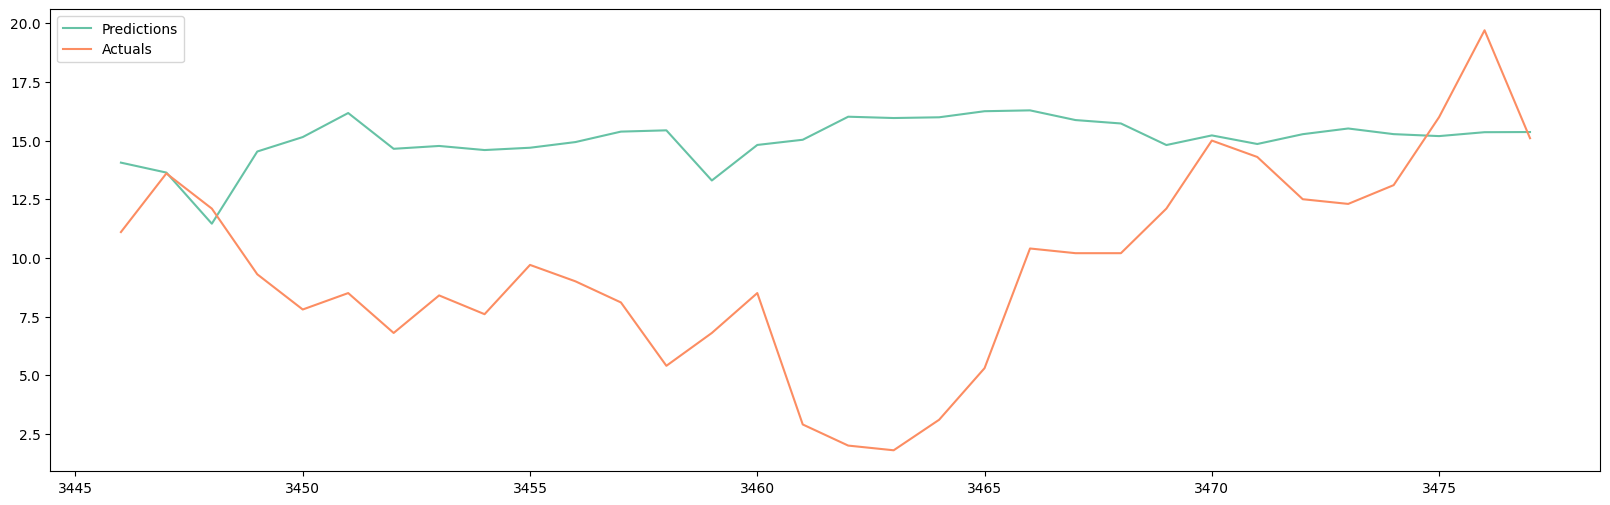

41/41 [==============================] - 0s 7ms/step


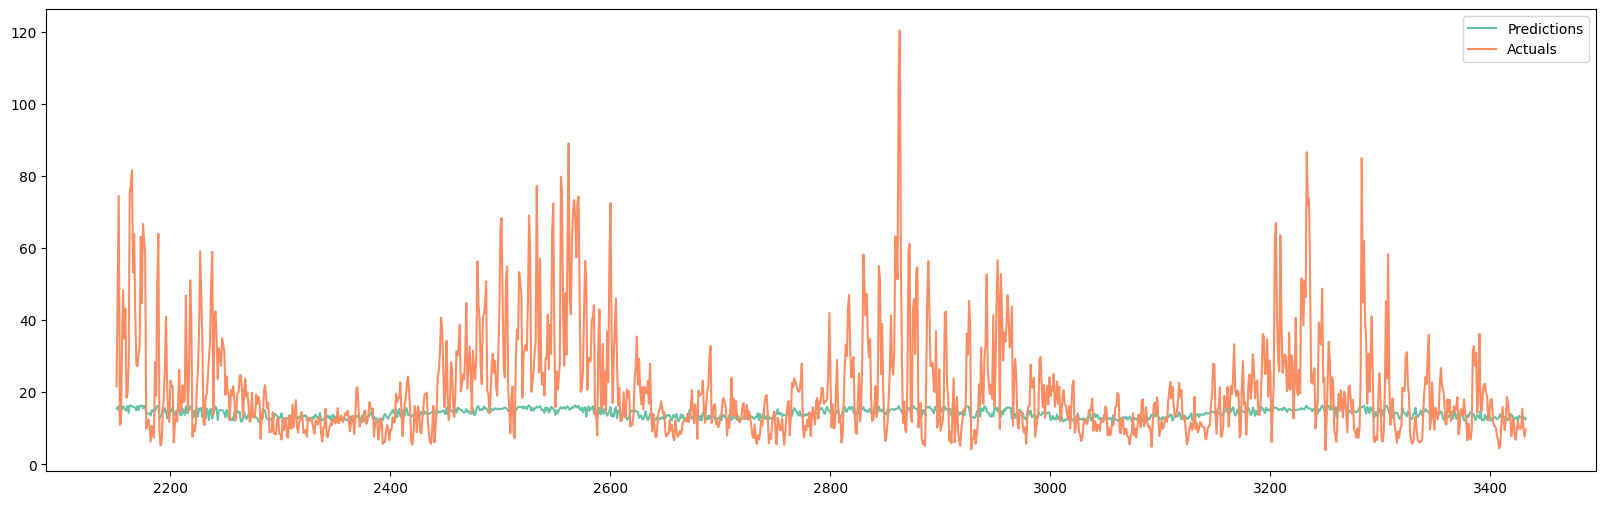

1/1 [==============================] - 0s 18ms/step


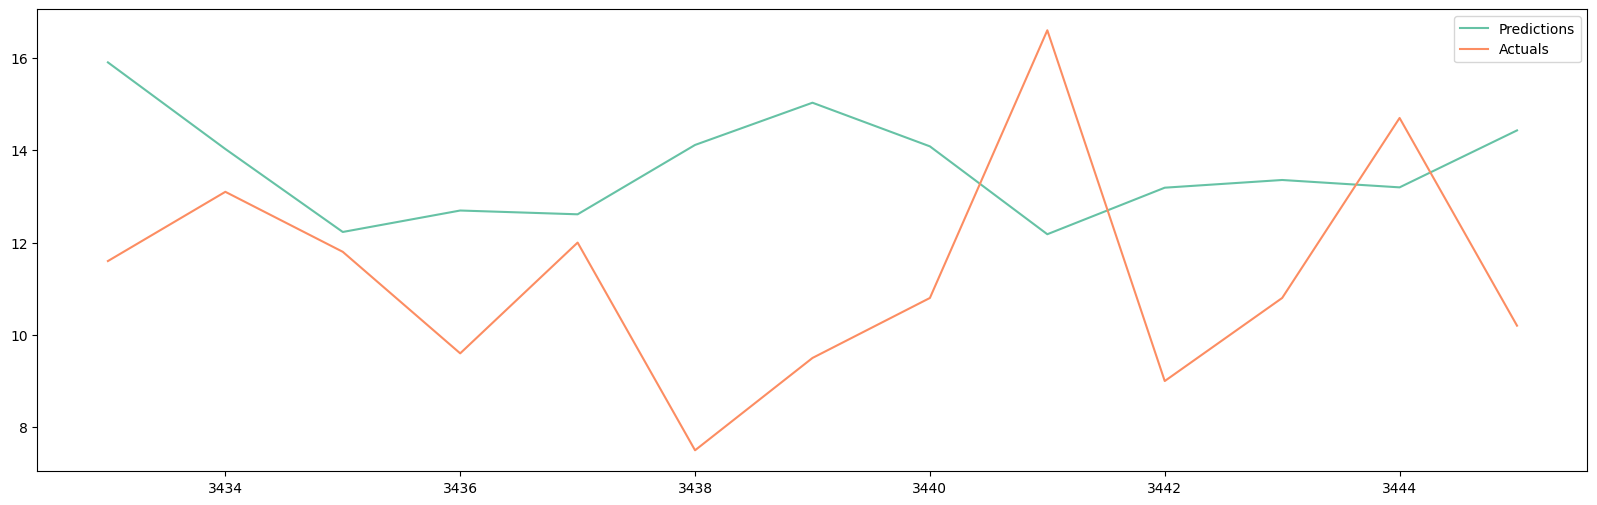

13.72633821936996
1/1 [==============================] - 0s 17ms/step


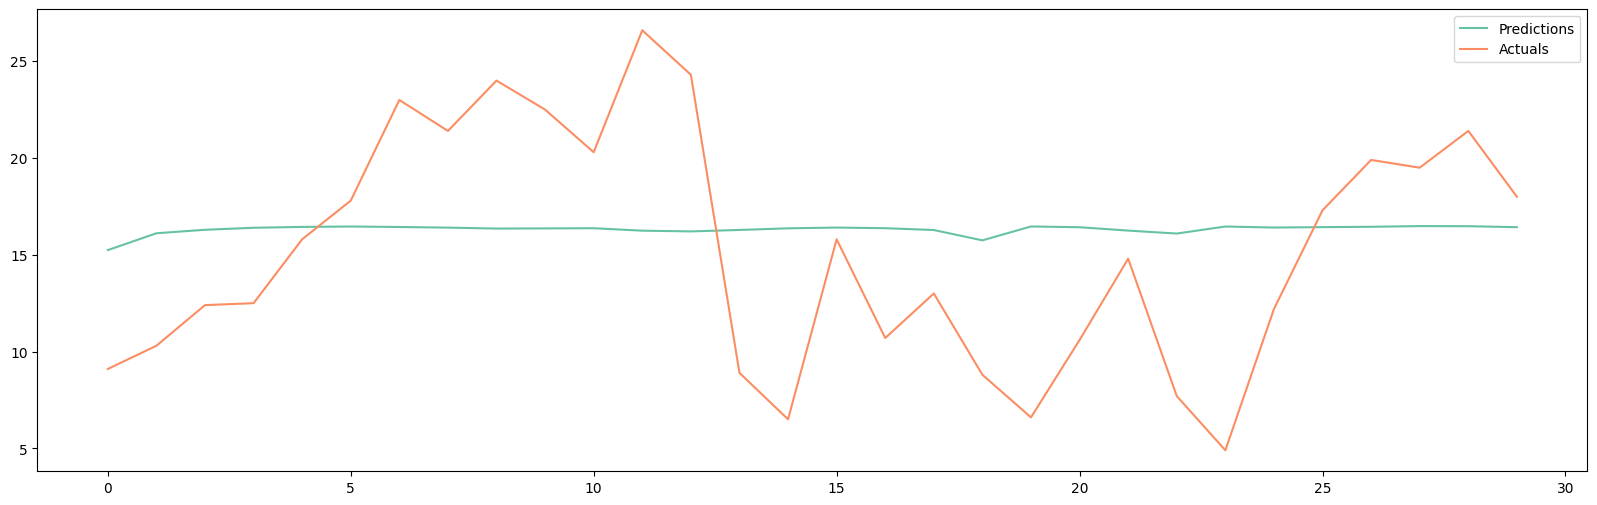

Procent dobrze przewidzianych: 66.67%


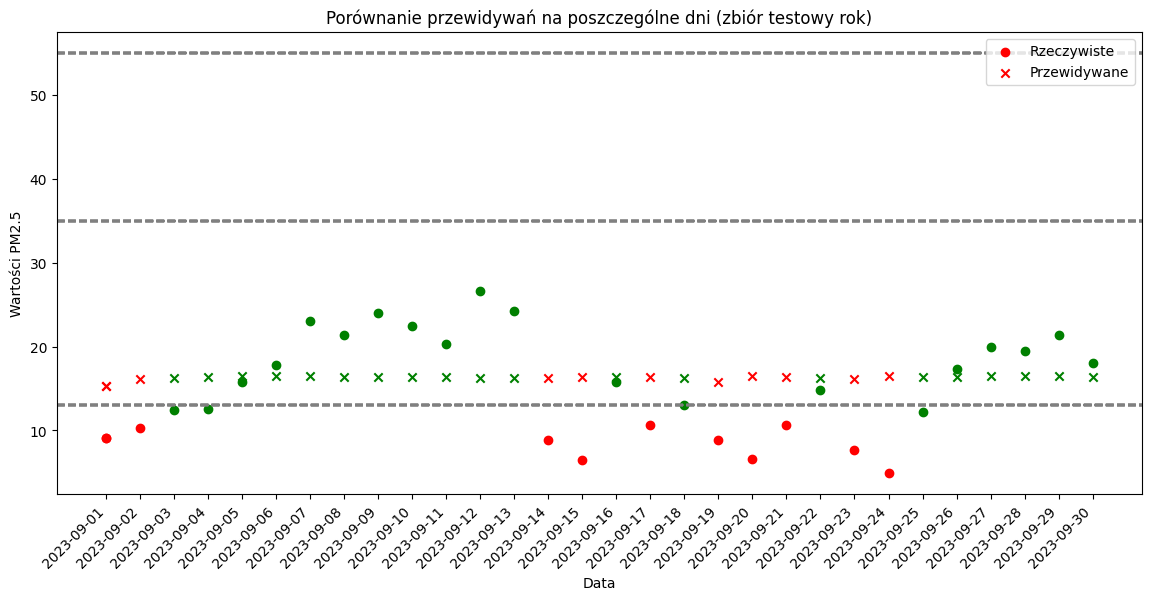

skuteczność:


In [40]:

from tensorflow.keras.models import load_model
loaded_model = load_model('model18/')

plot_predictions1(loaded_model, X_test_scaled.reshape((X_test_scaled.shape[0], 1, input_dim)), y_test)

plt.show()


predictions = loaded_model.predict(X_train_scaled.reshape((X_train_scaled.shape[0], 1, 6))).flatten()
df = pd.DataFrame(data={'Predictions': predictions, 'Actuals':y_train})
plt.plot(df['Predictions'][0:3347], label='Predictions')
plt.plot(df['Actuals'][0:3347], label='Actuals')
plt.legend()
plt.show()
predictions = loaded_model.predict(X_val_scaled.reshape((X_val_scaled.shape[0], 1, 6))).flatten()
df = pd.DataFrame(data={'Predictions': predictions, 'Actuals':y_val})
plt.plot(df['Predictions'][0:105], label='Predictions')
plt.plot(df['Actuals'][0:105], label='Actuals')
plt.legend()
plt.show()
print(mse(predictions, y_val))

def plot_predictions1(model, X, y, start=0, end=32):
  predictions = model.predict(X).flatten()
  df = pd.DataFrame(data={'Predictions': predictions, 'Actuals':y})
  plt.plot(df['Predictions'][start:end], label='Predictions')
  plt.plot(df['Actuals'][start:end], label='Actuals')

  plt.legend()
  plt.show()
  return df, mse(predictions, y)


model_data_test = pd.read_csv("../../przygotowanie_danych/model_data_test.csv")
df2 = model_data_test.drop(model_data_test.columns[[0,1,2,3,4]],axis = 1)
model_data_test = df2
model_data_test.describe()
model_data_test

X_test_test = model_data_test[["temperatura", "suma opadów", "wilgotność", "prędkość wiatru", "zachmurzenine", "day_number_in_year"]]
y_test_test = model_data_test['PM2.5']

X_test_test_scaled = scaler.transform(X_test_test)


predictions = loaded_model.predict(X_test_test_scaled.reshape((X_test_test_scaled.shape[0], 1, 6))).flatten()
df = pd.DataFrame(data={'Predictions': predictions, 'Actuals':y_test_test})
plt.plot(df['Predictions'][0:3347], label='Predictions')
plt.plot(df['Actuals'][0:3347], label='Actuals')
plt.legend()
plt.show()




def ocen_jakosc_powietrza(rzeczywiste, przewidywane):
    prog_bardzo_dobry = 12
    prog_dobry = 35
    prog_umiarkowany = 55
    prog_dostateczny = 75
    prog_zly = 110

    kategorie = {
        'bardzo_dobry': (0, prog_bardzo_dobry),
        'dobry': (prog_bardzo_dobry + 0.1, prog_dobry),
        'umiarkowany': (prog_dobry + 0.1, prog_umiarkowany),
        'dostateczny': (prog_umiarkowany + 0.1, prog_dostateczny),
        'zly': (prog_dostateczny + 0.1, prog_zly),
        'bardzo_zly': (prog_zly + 0.1, float('inf'))
    }

    def przyporzadkuj_kategorie(wartosc):
        for kategoria, (min_prog, max_prog) in kategorie.items():
            if min_prog <= wartosc <= max_prog:
                return kategoria

    rzeczywista_kategoria = przyporzadkuj_kategorie(rzeczywiste)
    przewidziana_kategoria = przyporzadkuj_kategorie(przewidywane)

    return rzeczywista_kategoria, przewidziana_kategoria


# Przykładowe dane - zastąp tym odpowiednimi danymi
results = pd.DataFrame({
    'Data': pd.date_range(start='2023-09-01', periods=30),
    'Rzeczywiste wartości (y_test)': y_test_test,
    'Przewidywane wartości (y_pred)': predictions
})

# Dodaj kolumny kategorii i porównania
results['Rzeczywista kategoria'], results['Przewidziana kategoria'] = zip(*results.apply(lambda row: ocen_jakosc_powietrza(row['Rzeczywiste wartości (y_test)'], row['Przewidywane wartości (y_pred)']), axis=1))
results['Zgadza się'] = results['Rzeczywista kategoria'] == results['Przewidziana kategoria']
legend_added = False  # Dodaj legendę tylko raz

# Wyodrębnij unikalne daty
unikalne_daty = results['Data'].unique()


procent_poprawnych = results['Zgadza się'].mean() * 100
print(f"Procent dobrze przewidzianych: {procent_poprawnych:.2f}%")


plt.figure(figsize=(14, 6))
sns.set_palette("Set2")  # Wybierz zestaw kolorów
for data in unikalne_daty:
    dane_dnia = results[results['Data'] == data]
    color = 'green' if dane_dnia['Zgadza się'].all() else 'red'
    
    
    if not legend_added:
        
        plt.scatter([data]*len(dane_dnia), dane_dnia['Rzeczywiste wartości (y_test)'],label='Rzeczywiste', color=color, marker='o')
        plt.scatter([data]*len(dane_dnia), dane_dnia['Przewidywane wartości (y_pred)'], label='Przewidywane',color=color, marker='x')
        legend_added = True

    plt.scatter([data]*len(dane_dnia), dane_dnia['Rzeczywiste wartości (y_test)'], color=color, marker='o')
    plt.scatter([data]*len(dane_dnia), dane_dnia['Przewidywane wartości (y_pred)'],color=color, marker='x')

    progi_jakosci_powietrza = [13, 35, 55]
    for prog in progi_jakosci_powietrza:
        plt.axhline(y=prog, color='gray', linestyle='--')
plt.legend(loc='upper right')
plt.title('Porównanie przewidywań na poszczególne dni (zbiór testowy rok)')
plt.xlabel('Data')
plt.ylabel('Wartości PM2.5')
plt.xticks(ticks=unikalne_daty, labels=[data.strftime('%Y-%m-%d') for data in unikalne_daty], rotation=45, ha='right')
plt.show()
print("skuteczność:",)




2/2 [==============================] - 0s 2ms/step


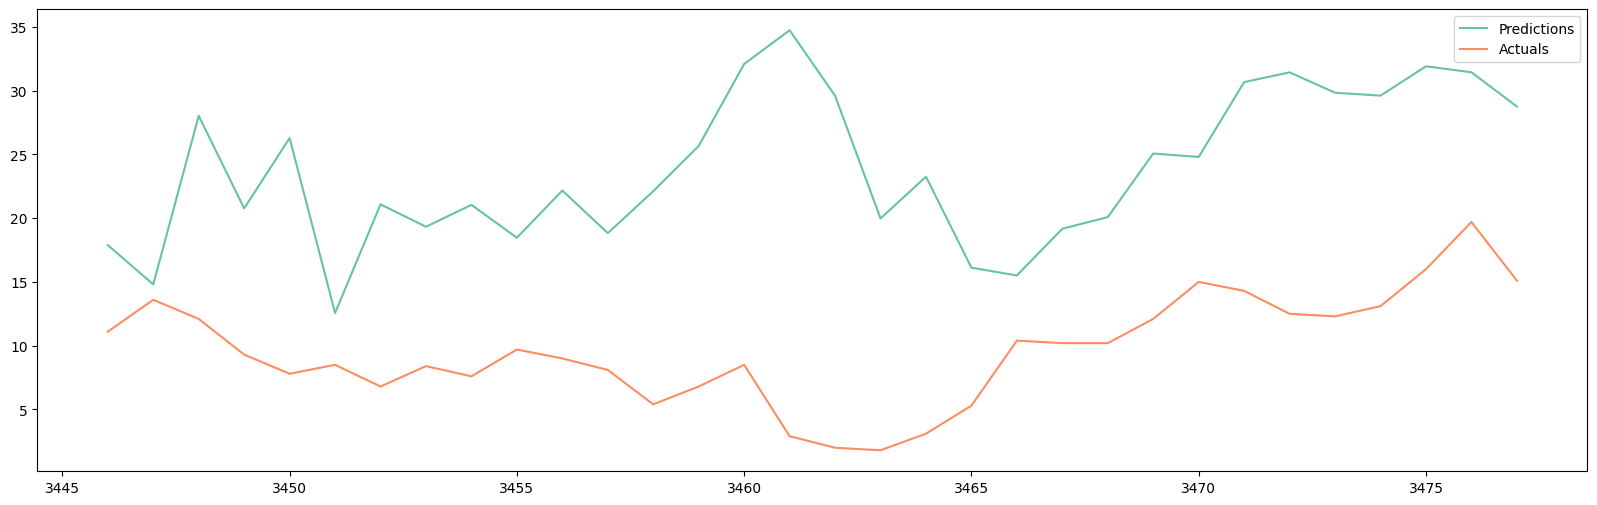

41/41 [==============================] - 0s 2ms/step


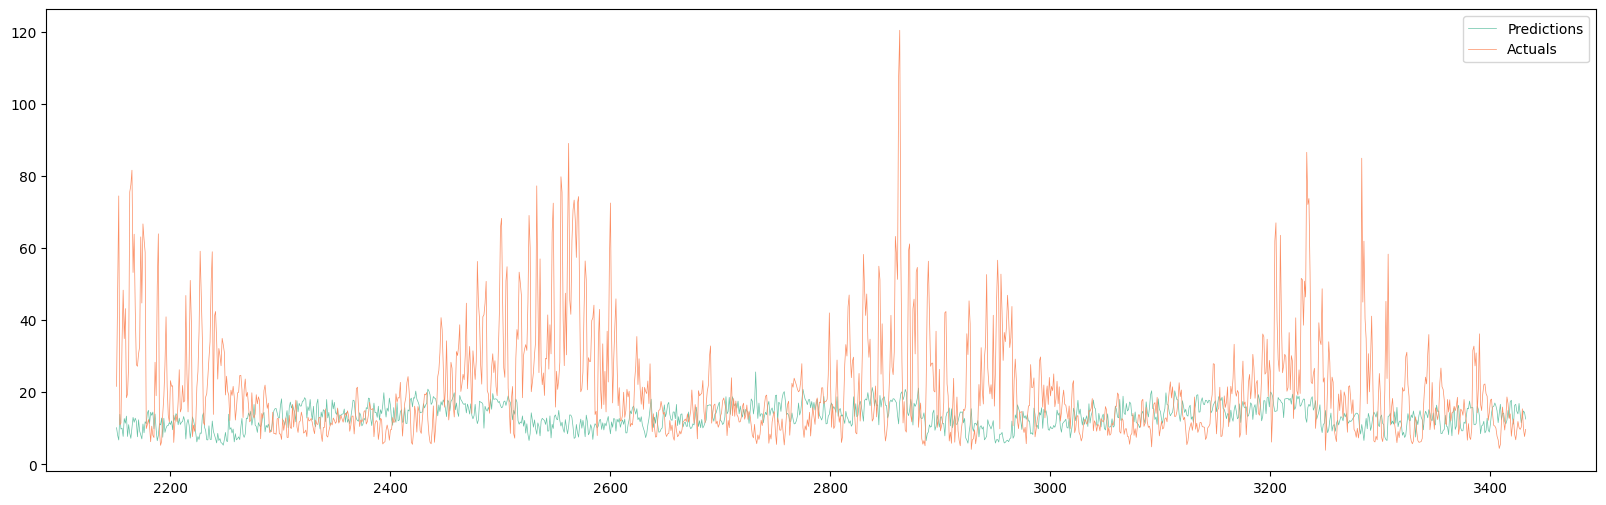

1/1 [==============================] - 0s 20ms/step


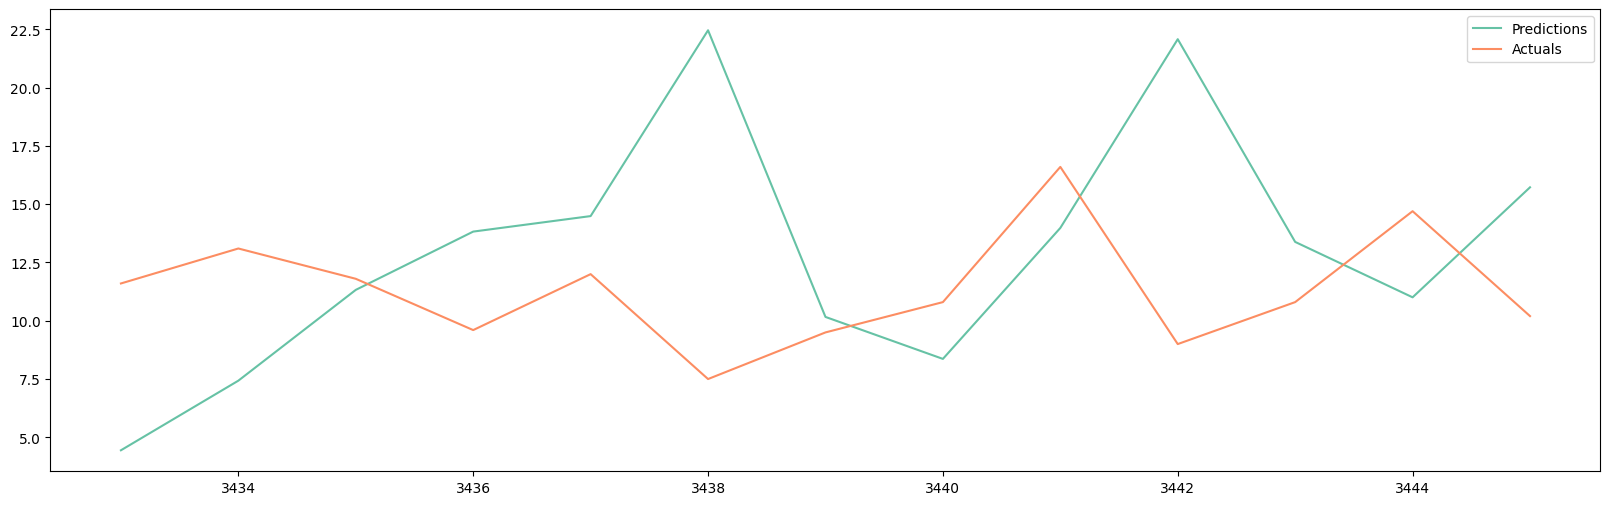

43.58099481128424
1/1 [==============================] - 0s 22ms/step


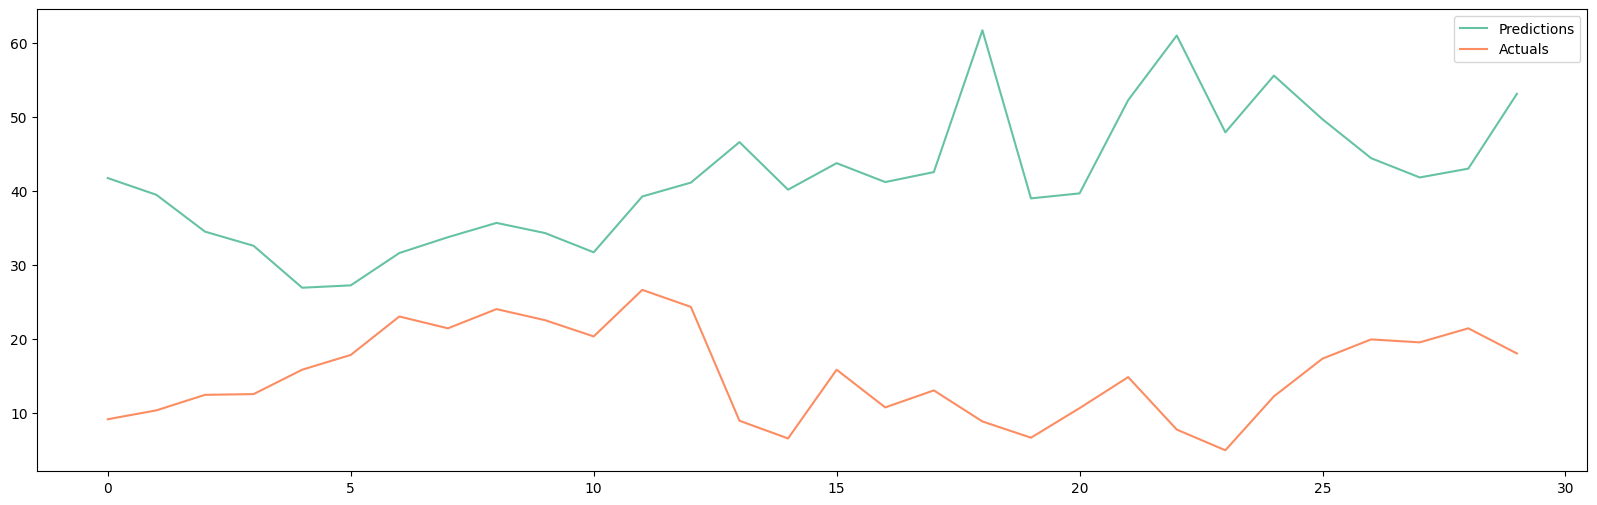

Procent dobrze przewidzianych: 26.67%


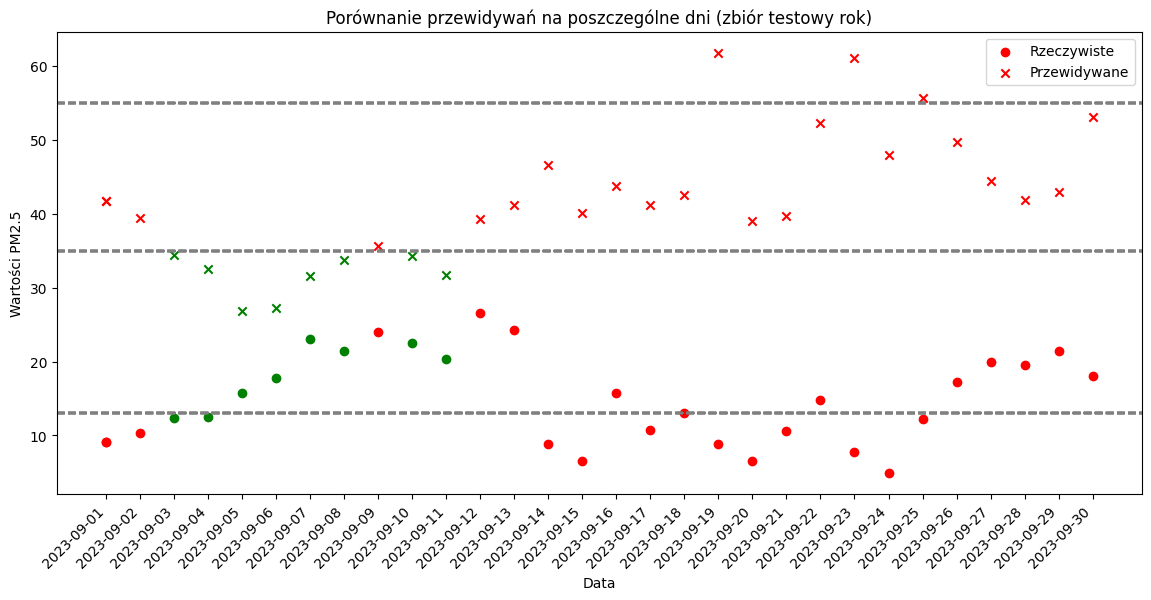

skuteczność:


In [41]:

from tensorflow.keras.models import load_model
loaded_model = load_model('model13/')

plot_predictions1(loaded_model, X_test_scaled.reshape((X_test_scaled.shape[0], 1, input_dim)), y_test)

plt.show()


predictions = loaded_model.predict(X_train_scaled.reshape((X_train_scaled.shape[0], 1, 6))).flatten()
df = pd.DataFrame(data={'Predictions': predictions, 'Actuals':y_train})
plt.plot(df['Predictions'][0:3347], label='Predictions',linewidth=0.5)
plt.plot(df['Actuals'][0:3347], label='Actuals',linewidth=0.5)
plt.legend()
plt.show()
predictions = loaded_model.predict(X_val_scaled.reshape((X_val_scaled.shape[0], 1, 6))).flatten()
df = pd.DataFrame(data={'Predictions': predictions, 'Actuals':y_val})
plt.plot(df['Predictions'][0:105], label='Predictions')
plt.plot(df['Actuals'][0:105], label='Actuals')
plt.legend()
plt.show()
print(mse(predictions, y_val))



predictions = loaded_model.predict(X_test_test_scaled.reshape((X_test_test_scaled.shape[0], 1, 6))).flatten()
df = pd.DataFrame(data={'Predictions': predictions, 'Actuals':y_test_test})
plt.plot(df['Predictions'][0:3347], label='Predictions')
plt.plot(df['Actuals'][0:3347], label='Actuals')
plt.legend()
plt.show()


def ocen_jakosc_powietrza(rzeczywiste, przewidywane):
    prog_bardzo_dobry = 12
    prog_dobry = 35
    prog_umiarkowany = 55
    prog_dostateczny = 75
    prog_zly = 110

    kategorie = {
        'bardzo_dobry': (0, prog_bardzo_dobry),
        'dobry': (prog_bardzo_dobry + 0.1, prog_dobry),
        'umiarkowany': (prog_dobry + 0.1, prog_umiarkowany),
        'dostateczny': (prog_umiarkowany + 0.1, prog_dostateczny),
        'zly': (prog_dostateczny + 0.1, prog_zly),
        'bardzo_zly': (prog_zly + 0.1, float('inf'))
    }

    def przyporzadkuj_kategorie(wartosc):
        for kategoria, (min_prog, max_prog) in kategorie.items():
            if min_prog <= wartosc <= max_prog:
                return kategoria

    rzeczywista_kategoria = przyporzadkuj_kategorie(rzeczywiste)
    przewidziana_kategoria = przyporzadkuj_kategorie(przewidywane)

    return rzeczywista_kategoria, przewidziana_kategoria


# Przykładowe dane - zastąp tym odpowiednimi danymi
results = pd.DataFrame({
    'Data': pd.date_range(start='2023-09-01', periods=30),
    'Rzeczywiste wartości (y_test)': y_test_test,
    'Przewidywane wartości (y_pred)': predictions
})

# Dodaj kolumny kategorii i porównania
results['Rzeczywista kategoria'], results['Przewidziana kategoria'] = zip(*results.apply(lambda row: ocen_jakosc_powietrza(row['Rzeczywiste wartości (y_test)'], row['Przewidywane wartości (y_pred)']), axis=1))
results['Zgadza się'] = results['Rzeczywista kategoria'] == results['Przewidziana kategoria']
legend_added = False  # Dodaj legendę tylko raz

# Wyodrębnij unikalne daty
unikalne_daty = results['Data'].unique()


procent_poprawnych = results['Zgadza się'].mean() * 100
print(f"Procent dobrze przewidzianych: {procent_poprawnych:.2f}%")


plt.figure(figsize=(14, 6))
sns.set_palette("Set2")  # Wybierz zestaw kolorów
for data in unikalne_daty:
    dane_dnia = results[results['Data'] == data]
    color = 'green' if dane_dnia['Zgadza się'].all() else 'red'
    
    
    if not legend_added:
        
        plt.scatter([data]*len(dane_dnia), dane_dnia['Rzeczywiste wartości (y_test)'],label='Rzeczywiste', color=color, marker='o')
        plt.scatter([data]*len(dane_dnia), dane_dnia['Przewidywane wartości (y_pred)'], label='Przewidywane',color=color, marker='x')
        legend_added = True

    plt.scatter([data]*len(dane_dnia), dane_dnia['Rzeczywiste wartości (y_test)'], color=color, marker='o')
    plt.scatter([data]*len(dane_dnia), dane_dnia['Przewidywane wartości (y_pred)'],color=color, marker='x')

    progi_jakosci_powietrza = [13, 35, 55]
    for prog in progi_jakosci_powietrza:
        plt.axhline(y=prog, color='gray', linestyle='--')
plt.legend(loc='upper right')
plt.title('Porównanie przewidywań na poszczególne dni (zbiór testowy rok)')
plt.xlabel('Data')
plt.ylabel('Wartości PM2.5')
plt.xticks(ticks=unikalne_daty, labels=[data.strftime('%Y-%m-%d') for data in unikalne_daty], rotation=45, ha='right')
plt.show()
print("skuteczność:",)


***Testy***   


In [37]:
def plot_predictions1(model, X, y, start=0, end=32):
  predictions = model.predict(X).flatten()
  df = pd.DataFrame(data={'Predictions': predictions, 'Actuals':y})
  plt.plot(df['Predictions'][start:end], label='Predictions')
  plt.plot(df['Actuals'][start:end], label='Actuals')

  plt.legend()
  plt.show()
  return df, mse(predictions, y)


model_data_test = pd.read_csv("../../przygotowanie_danych/model_data_test.csv")
df2 = model_data_test.drop(model_data_test.columns[[0,1,2,3,4]],axis = 1)
model_data_test = df2
model_data_test.describe()
model_data_test

X_test_test = model_data_test[["temperatura", "suma opadów", "wilgotność", "prędkość wiatru", "zachmurzenine", "day_number_in_year"]]
y_test_test = model_data_test['PM2.5']

X_test_test_scaled = scaler.transform(X_test_test)

from tensorflow.keras.models import load_model

loaded_model = load_model('model11/')

timesteps = 1
features = X_test_test_scaled.shape[1]

plot_predictions1(loaded_model, X_test_test_scaled.reshape((X_test_test_scaled.shape[0], timesteps, features)), y_test_test)


ValueError: in user code:

    File "/home/tomasz/Pulpit/inzynierka/.venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "/home/tomasz/Pulpit/inzynierka/.venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/tomasz/Pulpit/inzynierka/.venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "/home/tomasz/Pulpit/inzynierka/.venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 2381, in predict_step
        return self(x, training=False)
    File "/home/tomasz/Pulpit/inzynierka/.venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/tomasz/Pulpit/inzynierka/.venv/lib/python3.11/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_67" is incompatible with the layer: expected shape=(None, 4, 1), found shape=(None, 1, 6)


1/1 [==============================] - 0s 206ms/step


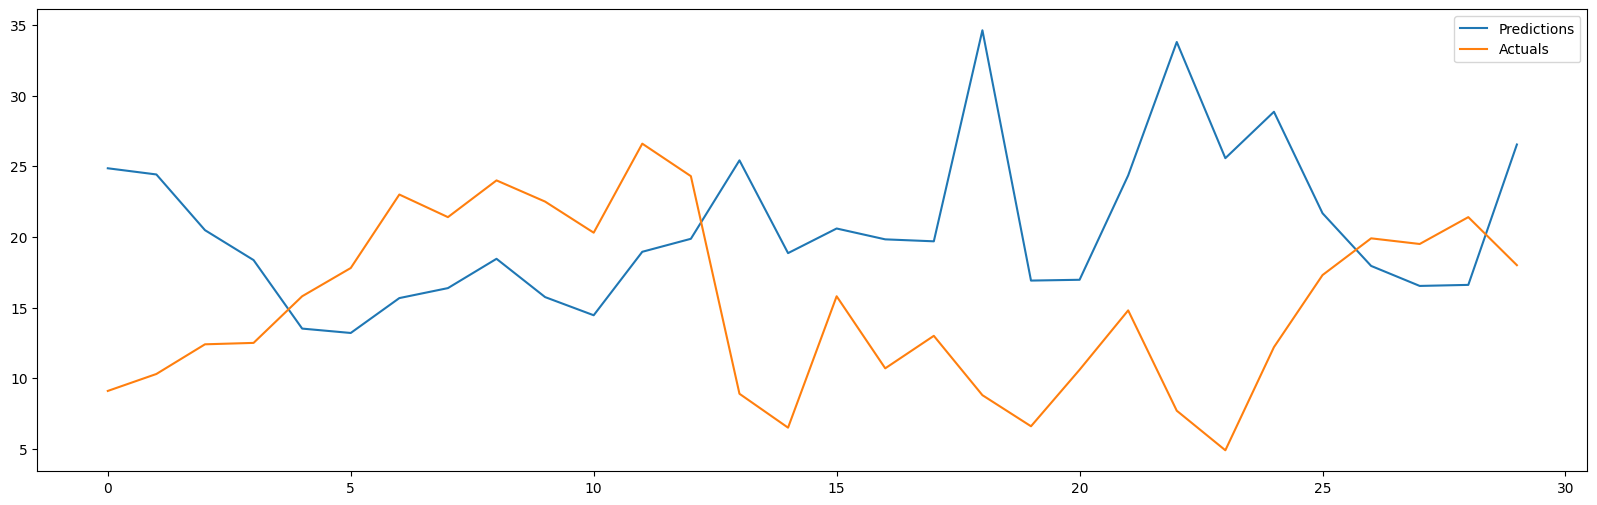

(    Predictions  Actuals
 0     24.858150      9.1
 1     24.420227     10.3
 2     20.478251     12.4
 3     18.360907     12.5
 4     13.512153     15.8
 5     13.202273     17.8
 6     15.671089     23.0
 7     16.377337     21.4
 8     18.451096     24.0
 9     15.741303     22.5
 10    14.455703     20.3
 11    18.947578     26.6
 12    19.867266     24.3
 13    25.418282      8.9
 14    18.853231      6.5
 15    20.595697     15.8
 16    19.827814     10.7
 17    19.688635     13.0
 18    34.624744      8.8
 19    16.910023      6.6
 20    16.967094     10.6
 21    24.353071     14.8
 22    33.795013      7.7
 23    25.573372      4.9
 24    28.856581     12.2
 25    21.674797     17.3
 26    17.947380     19.9
 27    16.531366     19.5
 28    16.605589     21.4
 29    26.540922     18.0,
 127.88196868981122)

In [38]:

loaded_model = load_model('model12/')

timesteps = 1
features = X_test_test_scaled.shape[1]

plot_predictions1(loaded_model, X_test_test_scaled.reshape((X_test_test_scaled.shape[0], timesteps, features)), y_test_test)

1/1 [==============================] - 0s 336ms/step


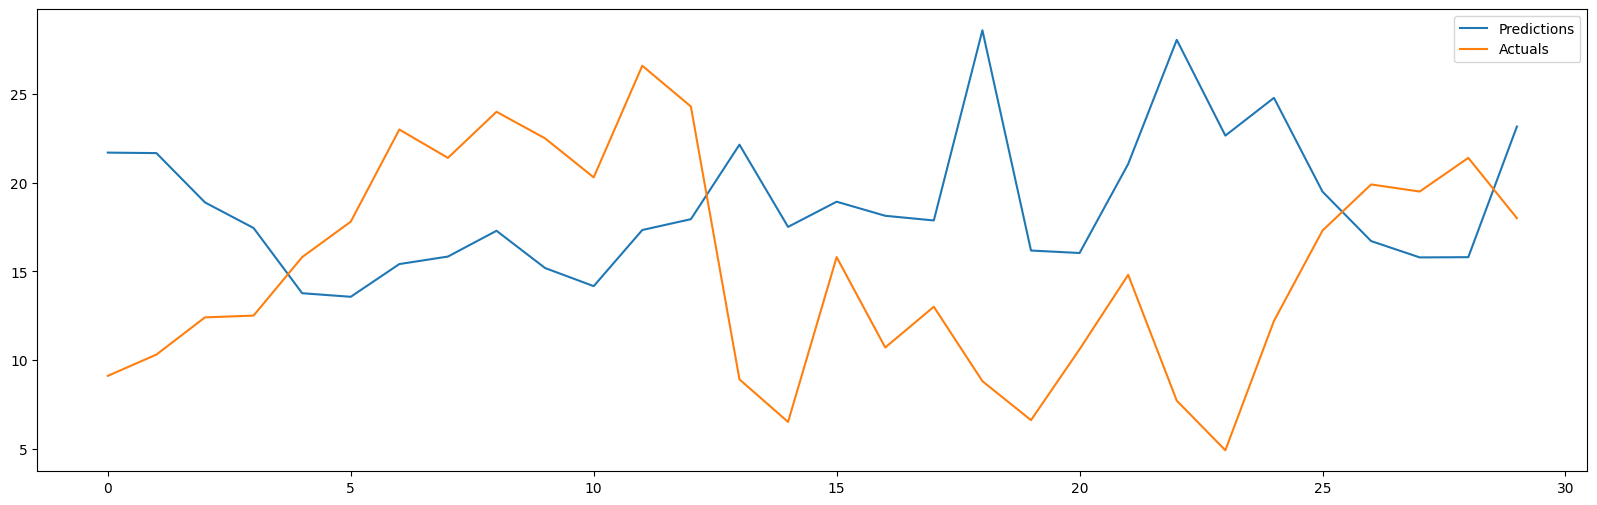

(    Predictions  Actuals
 0     21.696505      9.1
 1     21.669531     10.3
 2     18.886137     12.4
 3     17.443371     12.5
 4     13.763034     15.8
 5     13.560987     17.8
 6     15.407705     23.0
 7     15.831963     21.4
 8     17.286203     24.0
 9     15.183565     22.5
 10    14.161997     20.3
 11    17.329306     26.6
 12    17.941113     24.3
 13    22.145807      8.9
 14    17.505518      6.5
 15    18.926952     15.8
 16    18.132099     10.7
 17    17.868853     13.0
 18    28.600348      8.8
 19    16.171562      6.6
 20    16.031813     10.6
 21    21.055571     14.8
 22    28.060143      7.7
 23    22.656303      4.9
 24    24.786270     12.2
 25    19.492022     17.3
 26    16.704268     19.9
 27    15.783582     19.5
 28    15.796575     21.4
 29    23.167437     18.0,
 88.02116669838591)

In [50]:

loaded_model = load_model('model13/')

timesteps = 1
features = X_test_test_scaled.shape[1]

plot_predictions1(loaded_model, X_test_test_scaled.reshape((X_test_test_scaled.shape[0], timesteps, features)), y_test_test)



1/1 [==============================] - 0s 432ms/step


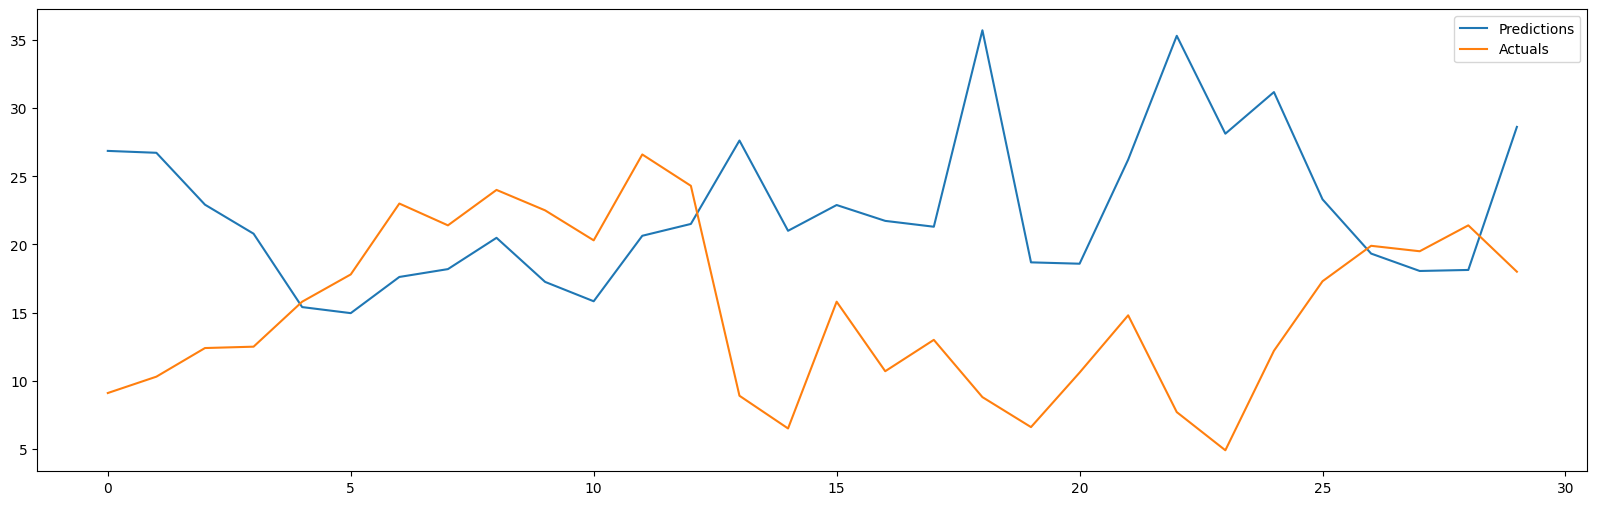

(    Predictions  Actuals
 0     26.861675      9.1
 1     26.722731     10.3
 2     22.916410     12.4
 3     20.788168     12.5
 4     15.404305     15.8
 5     14.960309     17.8
 6     17.614468     23.0
 7     18.190393     21.4
 8     20.485590     24.0
 9     17.251860     22.5
 10    15.831046     20.3
 11    20.635307     26.6
 12    21.503883     24.3
 13    27.622513      8.9
 14    21.000896      6.5
 15    22.891262     15.8
 16    21.728291     10.7
 17    21.299282     13.0
 18    35.710434      8.8
 19    18.685535      6.6
 20    18.586147     10.6
 21    26.223562     14.8
 22    35.305210      7.7
 23    28.123432      4.9
 24    31.177183     12.2
 25    23.307606     17.3
 26    19.328960     19.9
 27    18.053129     19.5
 28    18.128321     21.4
 29    28.622293     18.0,
 153.4973217177344)

In [51]:
loaded_model = load_model('model14/')

timesteps = 1
features = X_test_test_scaled.shape[1]

plot_predictions1(loaded_model, X_test_test_scaled.reshape((X_test_test_scaled.shape[0], timesteps, features)), y_test_test)


In [5]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping
import optuna

# early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

timesteps = 1
features = X_train_scaled.shape[1]
def objective(trial):


    model = Sequential()
    model.add(Bidirectional(LSTM(100, activation='relu',input_shape=(timesteps, features), return_sequences=True)))
    model.add(Dense(1, 'linear'))
    lr = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
    model.compile(optimizer=Adam(learning_rate=lr), loss=MeanSquaredError(), metrics='mse')

    cp = ModelCheckpoint('model11/', save_best_only=True, monitor='val_loss')
    early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
    model.fit(X_train_scaled.reshape((X_train_scaled.shape[0], timesteps, features)), y_train, 
              validation_data=(X_val_scaled.reshape((X_val_scaled.shape[0], timesteps, features)), y_val),
              epochs=50, callbacks=[cp, early_stopping], verbose=0)

    # Zwracanie wartości funkcji celu - w tym przypadku, błędu na zbiorze walidacyjnym
    return model.evaluate(X_val_scaled.reshape((X_val_scaled.shape[0], timesteps, features)), y_val)[0]

# Ustawienia optymalizacji
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)  # Możesz dostosować liczbę prób (n_trials)

# Wyświetlanie wyników optymalizacji
print('Best trial:')
trial = study.best_trial
print('Value: ', trial.value)
print('Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

/home/tomasz/Pulpit/inzynierka/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2023-12-04 19:47:41,412] A new study created in memory with name: no-name-00e71e5d-7f5f-45ea-8313-166bd26b8db5
/tmp/ipykernel_4027/4271322008.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


5/5 [==============================] - 0s 2ms/step - loss: 388.7948 - mse: 388.7948


[I 2023-12-04 19:48:03,883] Trial 0 finished with value: 388.7947998046875 and parameters: {'learning_rate': 0.0007617180807497869}. Best is trial 0 with value: 388.7947998046875.
/tmp/ipykernel_4027/4271322008.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


5/5 [==============================] - 0s 2ms/step - loss: 172.4691 - mse: 172.4691


[I 2023-12-04 19:49:44,526] Trial 1 finished with value: 172.46908569335938 and parameters: {'learning_rate': 6.312613265224586e-05}. Best is trial 1 with value: 172.46908569335938.
/tmp/ipykernel_4027/4271322008.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


5/5 [==============================] - 0s 2ms/step - loss: 347.7083 - mse: 347.7083


[I 2023-12-04 19:50:27,401] Trial 2 finished with value: 347.7083435058594 and parameters: {'learning_rate': 0.000617574047872373}. Best is trial 1 with value: 172.46908569335938.
/tmp/ipykernel_4027/4271322008.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


5/5 [==============================] - 0s 2ms/step - loss: 182.7450 - mse: 182.7450


[I 2023-12-04 19:53:28,664] Trial 3 finished with value: 182.7449951171875 and parameters: {'learning_rate': 1.7982800890901e-05}. Best is trial 1 with value: 172.46908569335938.
/tmp/ipykernel_4027/4271322008.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


5/5 [==============================] - 0s 2ms/step - loss: 360.1678 - mse: 360.1678


[I 2023-12-04 19:53:53,010] Trial 4 finished with value: 360.16778564453125 and parameters: {'learning_rate': 0.0006850905498960171}. Best is trial 1 with value: 172.46908569335938.
/tmp/ipykernel_4027/4271322008.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


5/5 [==============================] - 0s 2ms/step - loss: 697.6445 - mse: 697.6445


[I 2023-12-04 19:54:13,422] Trial 5 finished with value: 697.64453125 and parameters: {'learning_rate': 0.07889080335323666}. Best is trial 1 with value: 172.46908569335938.
/tmp/ipykernel_4027/4271322008.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


5/5 [==============================] - 0s 4ms/step - loss: 171.6094 - mse: 171.6094


[I 2023-12-04 19:55:59,728] Trial 6 finished with value: 171.60935974121094 and parameters: {'learning_rate': 6.288778272349894e-05}. Best is trial 6 with value: 171.60935974121094.
/tmp/ipykernel_4027/4271322008.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


5/5 [==============================] - 0s 2ms/step - loss: 130.3840 - mse: 130.3840


[I 2023-12-04 19:58:56,954] Trial 7 finished with value: 130.38401794433594 and parameters: {'learning_rate': 2.450727719660333e-05}. Best is trial 7 with value: 130.38401794433594.
/tmp/ipykernel_4027/4271322008.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


5/5 [==============================] - 0s 2ms/step - loss: 523.2234 - mse: 523.2234


[I 2023-12-04 19:59:16,160] Trial 8 finished with value: 523.223388671875 and parameters: {'learning_rate': 0.009823034929718795}. Best is trial 7 with value: 130.38401794433594.
/tmp/ipykernel_4027/4271322008.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


5/5 [==============================] - 0s 2ms/step - loss: 788.1656 - mse: 788.1656


[I 2023-12-04 19:59:32,726] Trial 9 finished with value: 788.1655883789062 and parameters: {'learning_rate': 0.014769001593181065}. Best is trial 7 with value: 130.38401794433594.


Best trial:
Value:  130.38401794433594
Params: 
    learning_rate: 2.450727719660333e-05
